In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble,plotting
from tools.mlr import mlr,proc_mlrfcst,maria_IO
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40969 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/haiyan/dask-worker-space/worker-0369rwsl', purging
distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/haiyan/dask-worker-space/worker-dox9a36a', purging
/tmp/ipykernel_1463351/453806833.py:24: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
class retrieve_cartesian:
    def __init__(self,PCA_dict=None,Af_dict=None,numcomp=[11,11,15],LT=None,forecastPC=None,target='all',suffix=None):
        self.PCA_dict=PCA_dict
        self.numcomp=numcomp
        self.forecastPC = forecastPC
        self.LT = LT
        self.target=target
        self.suffix=suffix
        
    def get_time_diff_terms(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(exp,timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                    #store.append(np.concatenate((a,azero),axis=0))
                else:
                    continue
                    #store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict
    
    def _pop_valid_test(self,examplist=None,validindex=None,testindex=None):
        [examplist.pop(i) for i in validindex]
        [examplist.pop(i) for i in testindex]
        return None
        
    def windrates_real(self,uvwheatpath=None,LT=None,category='train',validindex=[1,6],testindex=[2,12]):
        u = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['u'] for lime in tqdm(range(1,21))].copy()
        v = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['v'] for lime in tqdm(range(1,21))].copy()
        w = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['w'] for lime in tqdm(range(1,21))].copy()
        theta = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['theta'] for lime in tqdm(range(1,21))].copy()
        
        if category=='train':
            self._pop_valid_test(u,validindex,testindex)
            self._pop_valid_test(v,validindex,testindex)
            self._pop_valid_test(w,validindex,testindex)
            self._pop_valid_test(theta,validindex,testindex)
            assert len(u)==16, 'wrong train-valid-test separation!'
            dtermsT = self.get_time_diff_terms(inputvar=[u,v,w,theta],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='valid':
            uv = [u[index] for index in validindex]
            vv = [v[index] for index in validindex]
            wv = [w[index] for index in validindex]
            thetav = [theta[index] for index in validindex]
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[uv,vv,wv,thetav],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='test':
            ut = [u[index] for index in testindex]
            vt = [v[index] for index in testindex]
            wt = [w[index] for index in testindex]
            thetat = [theta[index] for index in testindex]            
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])            
        
        dudt = np.concatenate([testx for testx in dtermsT['u']],axis=0)
        dvdt = np.concatenate([testx for testx in dtermsT['v']],axis=0)
        dwdt = np.concatenate([testx for testx in dtermsT['w']],axis=0)
        dthdt = np.concatenate([testx for testx in dtermsT['theta']],axis=0)
        del dtermsT
        gc.collect()
        return dudt,dvdt,dwdt,dthdt
    
    def output_reshapeRECON(self,forecast_eig=None):
        if (self.target=='surface') or (self.target=='alluv'):
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            return testrec_dudt,testrec_dvdt
        else:
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            testrec_dwdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]:self.numcomp[0]+self.numcomp[1]+self.numcomp[2]],(self.PCA_dict['w'].components_[0:self.numcomp[2]]))#.reshape((39,360,167))
            testrec_dthdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]+self.numcomp[2]:],(self.PCA_dict['theta'].components_[0:self.numcomp[3]]))#.reshape((39,360,167))
            return testrec_dudt,testrec_dvdt,testrec_dwdt,testrec_dthdt
        
    def conversion_predictPC(self,yforecast=None,mshpe=[39,360,167]):
        if self.target=='surface':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return (t1.reshape(t1.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t1.shape[0],mshpe[1]*mshpe[2]),(t2.reshape(t2.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t2.shape[0],mshpe[1]*mshpe[2])
        elif self.target=='alluv':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2
        elif self.target=='all': 
            t1,t2,t3,t4 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2,t3,t4
        
    def output_r2(self,FFWmodels=None,reducedX=None,realU=None,realV=None,realW=None,realTH=None,case='Haiyan'):
        yf = [models.predict(Xns) for (models,Xns) in zip(FFWmodels[:],reducedX[:])]
        mlr_r2 = []
        for i in (range(45)):#len(yf))):
            if case=='Maria':
                temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[39,360,167])
                mlr_r2.append(r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0)))
            elif case=='Haiyan':
                try:
                    temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0))
                    print(a)
                    mlr_r2.append(a)
                except:
                    temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                    print(a)
                    mlr_r2.append(a)
            del temp1,temp2
            gc.collect()
        return mlr_r2
    
def output_realdterms(haiyan_data=None,category='train',varnum=2,LT=24):
    if varnum==2:
        a,b,_,_ = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])
        return a,b
    elif varnum==4:
        a,b,c,d = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])     
        return a,b,c,d

#### Read

In [3]:
def train_valid_test(expvarlist=None,validindex=None,testindex=None,concat='Yes'):
    X_valid, X_test = [expvarlist[i] for i in validindex], [expvarlist[i] for i in testindex]
    X_train = expvarlist.copy()
    [X_train.pop(i) for i in validindex]
    [X_train.pop(i) for i in testindex]
    assert len(X_train)==16, 'wrong train-valid-test separation!'
    if concat=='Yes':
        return np.concatenate([X_train[i] for i in range(len(X_train))],axis=0), np.concatenate([X_valid[i] for i in range(len(X_valid))],axis=0), np.concatenate([X_test[i] for i in range(len(X_test))],axis=0)
    else:
        return X_train, X_valid, X_test
    
def delete_padding(inTS=None,outTS=None):
    output_nozero,input_nozero = [],[]
    for i in range(len(outTS[:,0])):
        temp = outTS[i,:]
        tempin = inTS[i,:]
        if temp.all()==0:
            continue
        else:
            output_nozero.append(temp)
            input_nozero.append(tempin)
    return input_nozero,output_nozero

In [4]:
lti = 24
model = read_and_proc.depickle('../output/haiyan/processed/pca/FFW/'+str(lti)+'/FFWmodels_cross7')
new_feature = read_and_proc.depickle('../output/haiyan/processed/pca/FFW/'+str(lti)+'/newfeature_cross7')
reducedX = read_and_proc.depickle('../output/haiyan/processed/pca/FFW/'+str(lti)+'/reducedX_cross7')

# Decomposed Terms
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/'
SWLWdict = read_and_proc.depickle(folderpath+'pca/decomp/SWLW'+'_'+'dict_g')
LWCSWCIRdict = read_and_proc.depickle(folderpath+'pca/decomp/LWCSWCIR'+'_'+'dict_g')
SWLWMEANdict = read_and_proc.depickle(folderpath+'pca/decomp/SWLW_MEAN_'+'_'+'dict_g')
LWCSWCIRMEANdict = read_and_proc.depickle(folderpath+'pca/decomp/LWCSWCIR_MEAN_'+'_'+'dict_g')

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/'
Xtrain = read_and_proc.depickle(folderpath+'pca/X/Xtrain'+'_'+'dict_g')
Xvalid = read_and_proc.depickle(folderpath+'pca/X/Xvalid'+'_'+'dict_g')
Xtest = read_and_proc.depickle(folderpath+'pca/X/Xtest'+'_'+'dict_g')
yall = read_and_proc.depickle(folderpath+'pca/y/allY'+'_'+'dict_g')

In [5]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

haiyan_u = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'] for lime in tqdm(range(1,21))],axis=0)
haiyan_v = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['v'] for lime in tqdm(range(1,21))],axis=0)
haiyan_w = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['w'] for lime in tqdm(range(1,21))],axis=0)
#haiyan_qv = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['qv'] for lime in tqdm(range(1,21))],axis=0)
haiyan_theta = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['theta'] for lime in tqdm(range(1,21))],axis=0)
#haiyan_heatsum = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['heatsum'] for lime in tqdm(range(1,21))],axis=0)
#haiyan_hdia = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['hdia'] for lime in tqdm(range(1,21))],axis=0)
#haiyan_rad = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['rad'] for lime in tqdm(range(1,21))],axis=0)
#haiyan_ir = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['ir'] for lime in tqdm(range(1,21))],axis=0)

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/'
PCAdict,dict2 = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict1_g'),read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g') #dict1: u,v,w,theta,hdia,rad; dict2:qv,ir
PCAdict['qv'] = (dict2['qv'])
PCAdict['ir'] = (dict2['ir'])

#dims = ['sample','flatarray']
#coords = dict(sample=np.linspace(0,haiyan_u.shape[0]-1,haiyan_u.shape[0]),flatarray=np.linspace(0,haiyan_u.shape[1]-1,haiyan_u.shape[1]))
#ds = xr.Dataset(coords=coords)
#haiyan_data=preproc_haiyan.build_a_xarray_dataset(ds=ds,varname=['u','v','w','theta','heatsum','hdia','rad','qv','ir'],\
#                                   varfile=[haiyan_u,haiyan_v,haiyan_w,haiyan_theta,haiyan_heatsum,haiyan_hdia,haiyan_rad,haiyan_qv,haiyan_ir],dims=dims,coords=coords)
#del haiyan_u,haiyan_v,haiyan_w,haiyan_theta,haiyan_heatsum,haiyan_hdia,haiyan_rad
#gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

#### Orig RAD to DECOMPOSED RAD

In [11]:
from sklearn.linear_model import LinearRegression
# Initiate model
nummem = [50,38,91,8]#[54,26,50,75]
linreg = LinearRegression()
lti = 24
ytrain = [yobj[0] for yobj in yall]

train_lw_proc,train_sw_proc = np.asarray(delete_padding(train_valid_test(SWLWdict['LW'],[1,6],[2,12],'Yes')[0],ytrain[int(lti)-1])[0]),np.asarray(delete_padding(train_valid_test(SWLWdict['SW'],[1,6],[2,12],'Yes')[0],ytrain[int(lti)-1])[0])
train_lwmean_proc,train_swmean_proc = np.asarray(delete_padding(train_valid_test(SWLWMEANdict['LW'],[1,6],[2,12],'Yes')[0],ytrain[int(lti)-1])[0]),np.asarray(delete_padding(train_valid_test(SWLWMEANdict['SW'],[1,6],[2,12],'Yes')[0],ytrain[int(lti)-1])[0])

train_irlw_proc,train_irsw_proc = np.asarray(delete_padding(train_valid_test(LWCSWCIRdict['IRLW'],[1,6],[2,12],'Yes')[0],ytrain[int(lti)-1])[0]),np.asarray(delete_padding(train_valid_test(LWCSWCIRdict['IRSW'],[1,6],[2,12],'Yes')[0],ytrain[int(lti)-1])[0])
#train_irlwmean_proc,train_irswmean_proc = np.asarray(delete_padding(train_valid_test(LWCSWCIRMEANdict['IRLW'],[1,6],[2,12],'Yes')[0],ytrain[int(lti)-1])[0]),np.asarray(delete_padding(train_valid_test(LWCSWCIRMEANdict['IRSW'],[1,6],[2,12],'Yes')[0],ytrain[int(lti)-1])[0])

In [6]:
class retrieve_cartesian:
    def __init__(self,PCA_dict=None,Af_dict=None,numcomp=[11,11,15],LT=None,forecastPC=None,target='all',suffix=None):
        self.PCA_dict=PCA_dict
        self.numcomp=numcomp
        self.forecastPC = forecastPC
        self.LT = LT
        self.target=target
        self.suffix=suffix
        
    def get_time_diff_terms(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(exp,timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                    #store.append(np.concatenate((a,azero),axis=0))
                else:
                    continue
                    #store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict
    
    def _pop_valid_test(self,examplist=None,validindex=None,testindex=None):
        [examplist.pop(i) for i in validindex]
        [examplist.pop(i) for i in testindex]
        return None
        
    def windrates_real(self,uvwheatpath=None,LT=None,category='train',validindex=[1,6],testindex=[2,12]):
        u = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['u'] for lime in tqdm(range(1,21))].copy()
        v = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['v'] for lime in tqdm(range(1,21))].copy()
        w = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['w'] for lime in tqdm(range(1,21))].copy()
        theta = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['theta'] for lime in tqdm(range(1,21))].copy()
        
        if category=='train':
            self._pop_valid_test(u,validindex,testindex)
            self._pop_valid_test(v,validindex,testindex)
            self._pop_valid_test(w,validindex,testindex)
            self._pop_valid_test(theta,validindex,testindex)
            assert len(u)==16, 'wrong train-valid-test separation!'
            dtermsT = self.get_time_diff_terms(inputvar=[u,v,w,theta],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='valid':
            uv = [u[index] for index in validindex]
            vv = [v[index] for index in validindex]
            wv = [w[index] for index in validindex]
            thetav = [theta[index] for index in validindex]
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[uv,vv,wv,thetav],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='test':
            ut = [u[index] for index in testindex]
            vt = [v[index] for index in testindex]
            wt = [w[index] for index in testindex]
            thetat = [theta[index] for index in testindex]            
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])            
        
        dudt = np.concatenate([testx for testx in dtermsT['u']],axis=0)
        dvdt = np.concatenate([testx for testx in dtermsT['v']],axis=0)
        dwdt = np.concatenate([testx for testx in dtermsT['w']],axis=0)
        dthdt = np.concatenate([testx for testx in dtermsT['theta']],axis=0)
        del dtermsT
        gc.collect()
        return dudt,dvdt,dwdt,dthdt
    
    def output_reshapeRECON(self,forecast_eig=None):
        if (self.target=='surface') or (self.target=='alluv'):
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            return testrec_dudt,testrec_dvdt
        else:
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            testrec_dwdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]:self.numcomp[0]+self.numcomp[1]+self.numcomp[2]],(self.PCA_dict['w'].components_[0:self.numcomp[2]]))#.reshape((39,360,167))
            testrec_dthdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]+self.numcomp[2]:],(self.PCA_dict['theta'].components_[0:self.numcomp[3]]))#.reshape((39,360,167))
            return testrec_dudt,testrec_dvdt,testrec_dwdt,testrec_dthdt
        
    def conversion_predictPC(self,yforecast=None,mshpe=[39,360,167]):
        if self.target=='surface':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return (t1.reshape(t1.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t1.shape[0],mshpe[1]*mshpe[2]),(t2.reshape(t2.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t2.shape[0],mshpe[1]*mshpe[2])
        elif self.target=='alluv':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2
        elif self.target=='all': 
            t1,t2,t3,t4 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2,t3,t4
        
    def output_r2(self,FFWmodels=None,reducedX=None,realU=None,realV=None,realW=None,realTH=None,case='Haiyan'):
        yf = [models.predict(Xns) for (models,Xns) in zip(FFWmodels[:],reducedX[:])]
        mlr_r2 = []
        for i in (range(45)):#len(yf))):
            if case=='Maria':
                temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[39,360,167])
                mlr_r2.append(r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0)))
            elif case=='Haiyan':
                try:
                    temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0))
                    print(a)
                    mlr_r2.append(a)
                except:
                    temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                    print(a)
                    mlr_r2.append(a)
            del temp1,temp2
            gc.collect()
        return mlr_r2

In [7]:
def replace_rad(reduced_X=None,alt_reducedX=None,numcomp=20,zeroout=True,extraterms=True):
    if zeroout:
        if extraterms:
            rad_only = reduced_X.copy()
            rad_only[:,-numcomp:] = 0
        else:
            rad_only = np.zeros_like(reduced_X)
            rad_only[:,-numcomp:] = reduced_X[:,-numcomp:]
            if alt_reducedX is not None:
                rad_only[:,-numcomp:] = alt_reducedX[:,-numcomp:]
    else:
        rad_only = reduced_X.copy()
        rad_only[:,-numcomp:] = alt_reducedX[:,-numcomp:]
    return rad_only

def prediction_to_cartesian(modelz=None,reducedX=None,alt_reducedX=None,shape=[10,360,208],target='alluv',task=None,replacerad=True):
    nummem = [50,38,91,8]
    if target=='alluv':
        if task=='decomp':
            if replacerad: radonly = replace_rad(reducedX,alt_reducedX,numcomp=20,zeroout=True,extraterms=False)
            else: radonly = replace_rad(reducedX,None,numcomp=20,zeroout=True,extraterms=False)
            a,b = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(radonly),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
            return a,b
        elif task=='intercept':
            #a,b = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
            #                   suffix=None).conversion_predictPC(np.tile(modelz.intercept_,(reducedX.shape[0],1)),shape) #np.zeros_like(reducedX)
            a,b = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
                               suffix=None).conversion_predictPC(np.tile(modelz.intercept_,(reducedX.shape[0],1)),shape) #np.zeros_like(reducedX)
            return a,b
        elif task=='extraterms':
            radonly = replace_rad(reducedX,alt_reducedX,numcomp=20,zeroout=True,extraterms=True)
            a,b = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
            return a,b            
    elif target=='all':
        if task=='decomp':
            if replacerad: radonly = replace_rad(reducedX,alt_reducedX,numcomp=20,zeroout=True,extraterms=False)
            else: radonly = replace_rad(reducedX,None,numcomp=20,zeroout=True,extraterms=False)
            a,b,c,d = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(radonly),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
            return a,b,c,d
        elif task=='intercept':
            #a,b,c,d = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
            #                   suffix=None).conversion_predictPC(np.tile(modelz.intercept_,(reducedX.shape[0],1)),shape)
            a,b,c,d = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(np.zeros_like(reducedX)),shape)
            return a,b,c,d
        elif task=='extraterms':
            radonly = replace_rad(reducedX,alt_reducedX,numcomp=20,zeroout=True,extraterms=True)
            a,b,c,d = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
            return a,b,c,d  
        
def prediction_to_cartesian_single(modelz=None,reducedX=None,alt_reducedX=None,shape=[10,360,208],target='alluv',comptarget=None):
    nummem = [50,38,91,8]
    if target=='alluv':
        radonly = np.zeros_like(reducedX)
        if alt_reducedX is not None:
            radonly[:,-comptarget] = alt_reducedX[:,-comptarget]
        else:
            radonly[:,-comptarget] = reducedX[:,-comptarget]
        #print(radonly[0,:])
        a,b = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(radonly),target=target,\
                                 suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
        return a,b
    elif target=='all':
        radonly = np.zeros_like(reducedX)
        if alt_reducedX is not None:
            radonly[:,-comptarget] = alt_reducedX[:,-comptarget]
        else:
            radonly[:,-comptarget] = reducedX[:,-comptarget]
        a,b,c,d = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(radonly),target=target,\
                                 suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
        return a,b,c,d

In [12]:
def rotate(matrix=None,angle=None):
    front,back = matrix[0:-angle,:],matrix[-angle:,:]
    newmatrix = np.concatenate((back,front),axis=0)
    return newmatrix
A = PCAdict['rad'].components_[1,:].reshape(10,360,208)[2,:,:]
Ar = rotate(A,60)

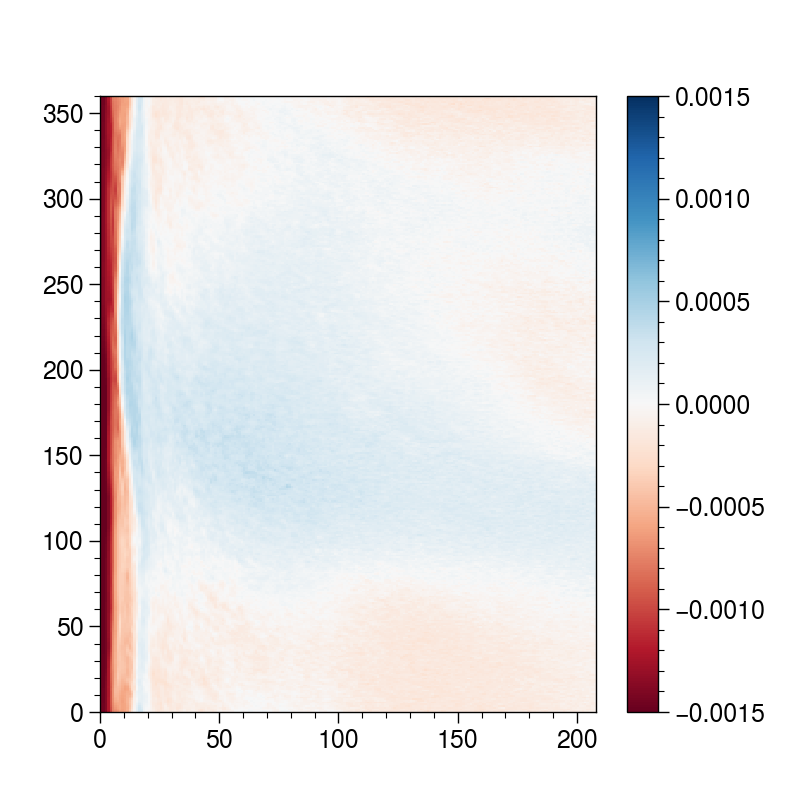

In [13]:
plt.pcolormesh(Ar,vmin=-0.0015,vmax=0.0015,cmap='RdBu')
plt.colorbar()
plt.show()

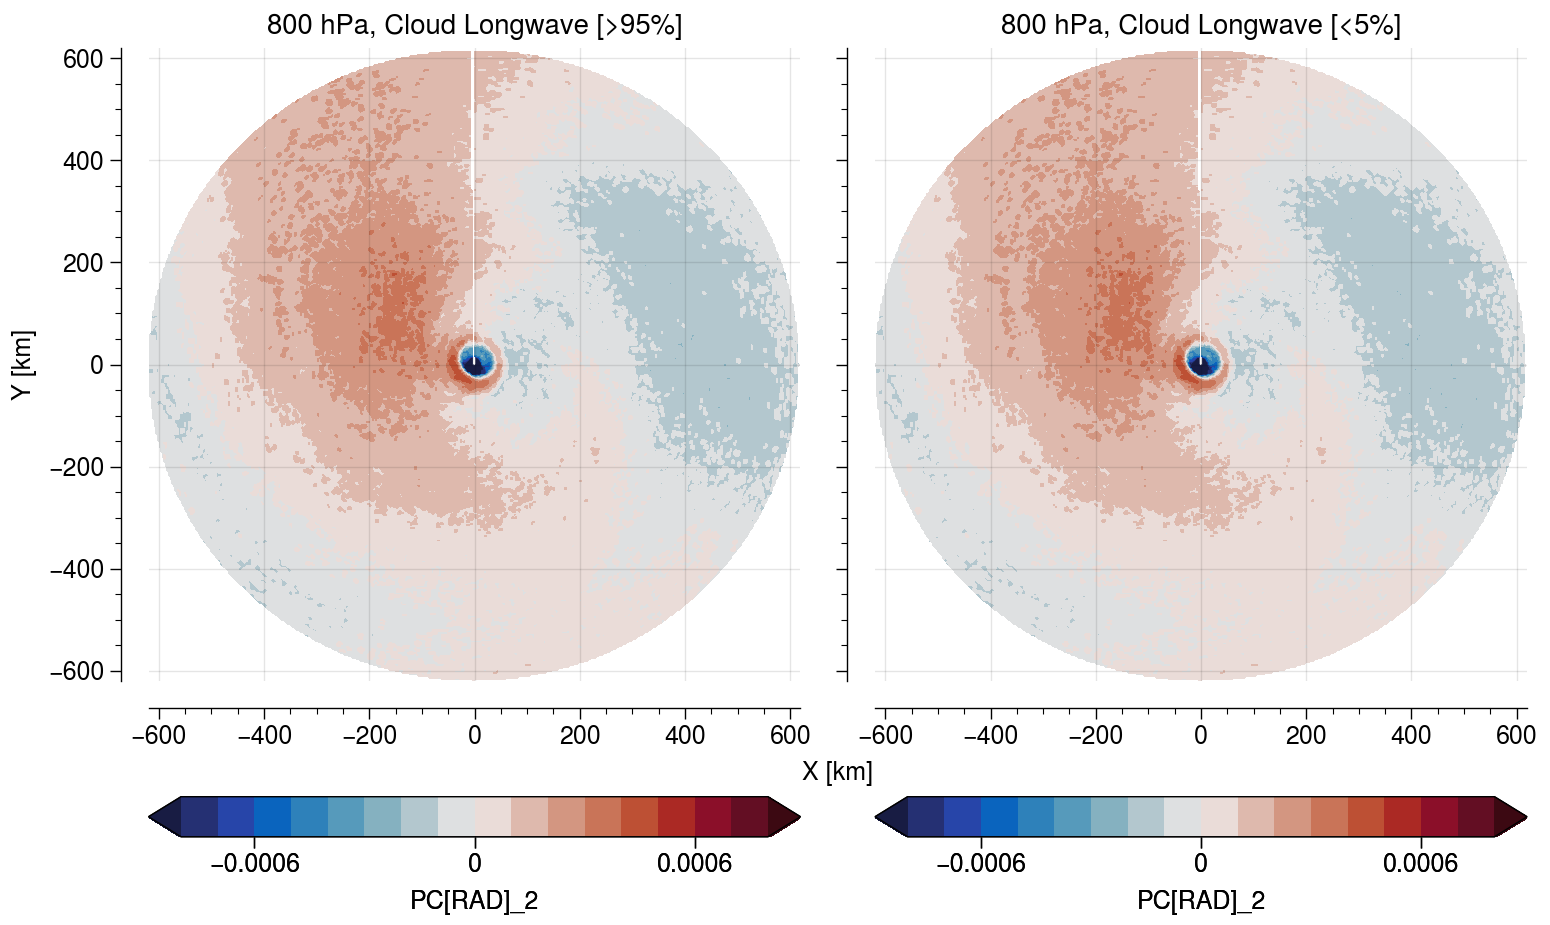

In [16]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))

fig, axs = plot.subplots(ncols=2,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)')
typelabel=['Cloud Longwave [>95%]','Cloud Longwave [<5%]']#['Cloud Longwave [>95%]','Cloud Longwave [<5%]']
for indices in range(2):
    #axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
    #                      np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(PCAdict['rad'].components_[1,:].reshape(10,360,208)[2,:,:],ANGLE,True,False)))),0),\
    #                     cmap='balance',levels=np.linspace(-0.0008,0.0008,17),colorbar='b',colorbar_kw={'format':'simple','ticks':0.0006,'label': 'PC[RAD]_2'},extend='both')
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
                          np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(Ar,ANGLE,True,False)))),0),\
                         cmap='balance',levels=np.linspace(-0.0008,0.0008,17),colorbar='b',colorbar_kw={'format':'simple','ticks':0.0006,'label': 'PC[RAD]_2'},extend='both')
    #axs[indices].streamplot(np.linspace(-207,207,416)*3,np.linspace(-207,207,416)*3,ut[indices],vt[indices], density=[1.25, 1.25],linewidth=0.5)
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'{800} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
#plt.savefig('../figures/0425/MLR_dvdtrecon_decompcheck_24hr_800_95_5_vect.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

In [11]:
def output_realdterms(category='train',varnum=2,LT=24):
    if varnum==2:
        a,b,_,_ = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])
        return a,b
    elif varnum==4:
        a,b,c,d = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])
        return a,b,c,d

lti=24
realdu,realdv,realdw,realdtheta = output_realdterms(category='train',varnum=4,LT=lti)
dudt_extra,dvdt_extra,dwdt_extra,dthdt_extra = prediction_to_cartesian(model[5],reducedX[5],None,[10,360,208],'all','extraterms',False)
dudt_full,dvdt_full,dwdt_full,dthdt_full = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=model[5].predict((reducedX[5])),target='all',\
                               suffix=None).conversion_predictPC(model[5].predict((reducedX[5])),[10,360,208])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

##### Retrieve decomposition

In [11]:
dudt_b,dvdt_b,dwdt_b,dthdt_b = prediction_to_cartesian(model[5],reducedX[5],None,[10,360,208],'all','intercept',False)
dudt_lw,dvdt_lw,dwdt_lw,dthdt_lw = prediction_to_cartesian(model[5],reducedX[5],train_lw_proc,[10,360,208],'all','decomp',True)
dudt_sw,dvdt_sw,dwdt_sw,dthdt_sw = prediction_to_cartesian(model[5],reducedX[5],train_sw_proc,[10,360,208],'all','decomp',True)
dudt_lwm,dvdt_lwm,dwdt_lwm,dthdt_lwm = prediction_to_cartesian(model[5],reducedX[5],train_lwmean_proc,[10,360,208],'all','decomp',True)
dudt_swm,dvdt_swm,dwdt_swm,dthdt_swm = prediction_to_cartesian(model[5],reducedX[5],train_swmean_proc,[10,360,208],'all','decomp',True)
dudt_irlw,dvdt_irlw,dwdt_irlw,dthdt_irlw = prediction_to_cartesian(model[5],reducedX[5],train_irlw_proc,[10,360,208],'all','decomp',True)
dudt_irsw,dvdt_irsw,dwdt_irsw,dthdt_irsw = prediction_to_cartesian(model[5],reducedX[5],train_irsw_proc,[10,360,208],'all','decomp',True)
dudt_clearlw,dvdt_clearlw,dwdt_clearlw,dthdt_clearlw = dudt_lw-dudt_irlw-dudt_lwm,dvdt_lw-dvdt_irlw-dvdt_lwm,dwdt_lw-dwdt_irlw-dwdt_lwm,dthdt_lw-dthdt_irlw-dthdt_lwm
dudt_clearsw,dvdt_clearsw,dwdt_clearsw,dthdt_clearsw = dudt_sw-dudt_irsw-dudt_swm,dvdt_sw-dvdt_irsw-dvdt_swm,dwdt_sw-dwdt_irsw-dwdt_swm,dthdt_sw-dthdt_irsw-dthdt_swm

########################################################################################################################
# One term
########################################################################################################################
#dudt_radpc2,dvdt_radpc2 = prediction_to_cartesian_single(model[5],reducedX[5],None,[10,360,208],'alluv',19)
#dudt_radpc6,dvdt_radpc6 = prediction_to_cartesian_single(model[5],reducedX[5],None,[10,360,208],'alluv',15)

In [13]:
rad_only = np.zeros_like(reducedX[5])
rad_only[:,-20:] = train_lw_proc[:,-20:]
dudt_lw,dvdt_lw = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=model[5].predict(rad_only),target='alluv',\
                               suffix=None).conversion_predictPC(model[5].predict(rad_only),[10,360,208])

##### Validation

/tmp/ipykernel_3566911/3318610179.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})


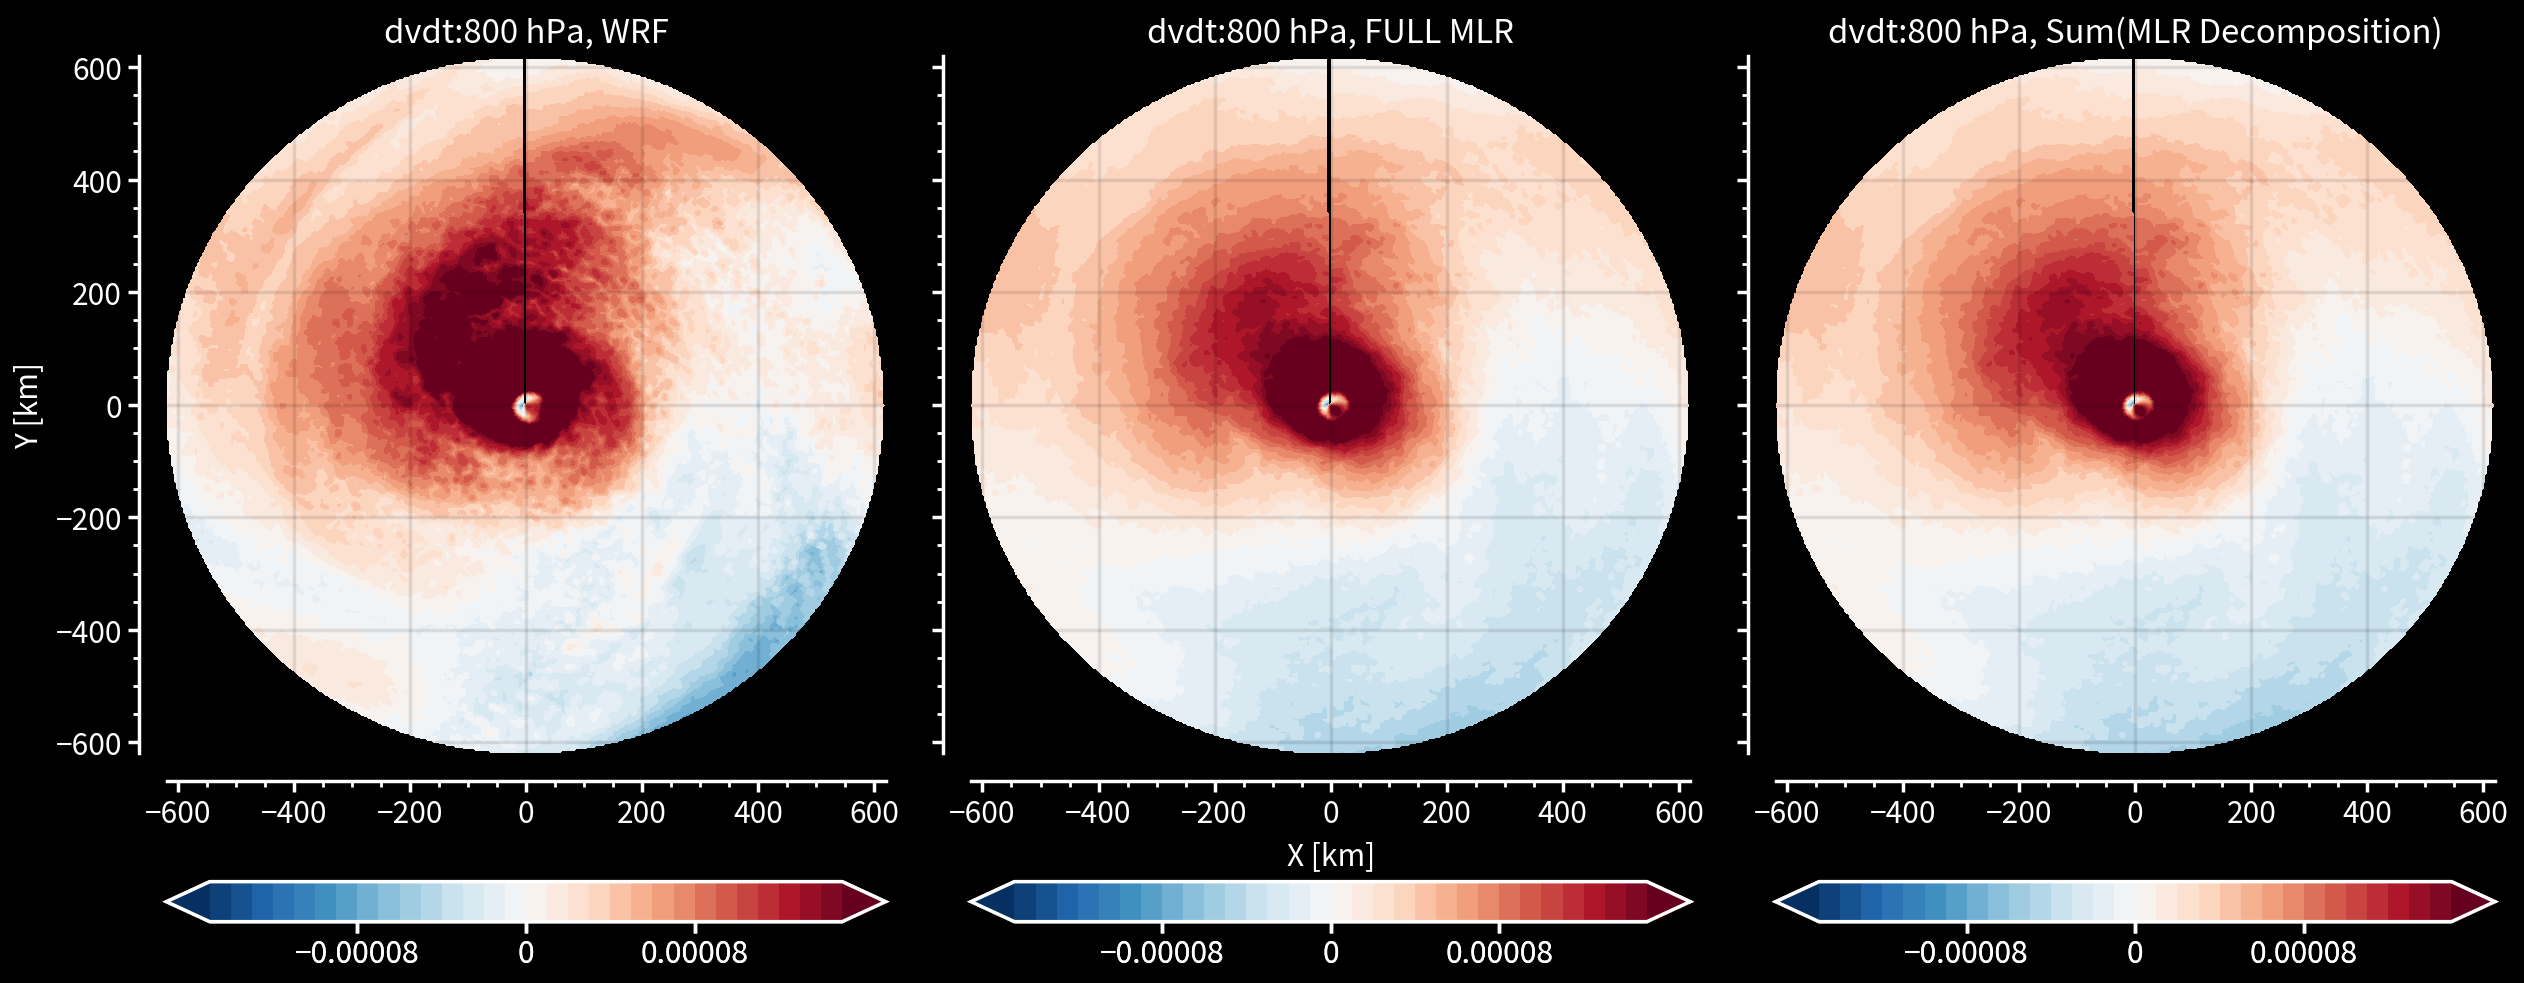

In [164]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

smpl = 406
y = [np.fliplr(np.flipud((proc_tocart((realdv.reshape(869,10,360,208))[smpl,2,...],ANGLE,True,False)))),np.fliplr(np.flipud((proc_tocart(((dvdt_full).reshape(869,10,360,208))[smpl,2,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((proc_tocart(((dvdt_extra+dvdt_b+dvdt_lw+dvdt_sw).reshape(869,10,360,208))[smpl,2,...],ANGLE,True,False))))]
typelabel=['WRF','FULL MLR','Sum(MLR Decomposition)']

fig, axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)')
for indices in range(3):
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-15e-5,15e-5,31),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00008},extend='both')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{800} hPa, {typelabel[indices]}')
    adjust_spines(axs[indices],['left','bottom'],10)
plt.savefig('../figures/0406/MLR_dvdtrecon_decompvalid.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

#### Decomposition

In [8]:
def proc_radial(polarfield=None,angle=None,twoD=True,standard=False):
    if twoD==True:
        PWnew = [np.asarray(polarfield)[int(np.abs(angle-360).argmin()),:]]
        for i in np.linspace(0,358,359):
            PWnew.append(np.asarray(polarfield)[int(np.abs(angle-i).argmin()),:])
        PWnew = np.swapaxes(np.asarray(PWnew),0,1)
        del i
        return PWnew

In [9]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))

In [72]:
d2r = np.pi/180
dudt_irlwr,dvdt_irlwr = proc_radial((dvdt_irlw.reshape(dudt_sw.shape[0],10,360,208))[smpl,2,...],ANGLE,True,False),proc_radial((dvdt_irlw.reshape(dvdt_sw.shape[0],10,360,208))[smpl,2,...],ANGLE,True,False)

In [104]:
def avg_subsampleUV(array=None,arrayref=None,index=None,vertlv=None):
    temp = [(proc_radial((array.reshape(array.shape[0],10,360,208))[index[smpl],vertlv,...],ANGLE,True,False)) for smpl in tqdm(range(len(index)))] #proc_radial((dvdt_irlw.reshape(dudt_sw.shape[0],10,360,208))[smpl,2,...],ANGLE,True,False)
    return np.mean(np.asarray(temp),axis=0)

In [193]:
percent95_indices = list(df[df['maxwindspeeds']>np.percentile(df['maxwindspeeds'],95)].index)
percent5_indices = list(df[df['maxwindspeeds']<np.percentile(df['maxwindspeeds'],5)].index)
hlv=2
u,v = [avg_subsampleUV((dudt_irlw),dudt_lw,percent95_indices,hlv),avg_subsampleUV((dudt_irlw),dudt_lw,percent5_indices,hlv)],[avg_subsampleUV((dvdt_irlw),dudt_lw,percent95_indices,hlv),avg_subsampleUV((dvdt_irlw),dudt_lw,percent5_indices,hlv)]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [194]:
u95,v95 = proc_tocartUV(u[0]*np.cos(ANGLE*d2r)+v[0]*np.sin(ANGLE*d2r)),proc_tocartUV(u[0]*np.sin(ANGLE*d2r)-v[0]*np.cos(ANGLE*d2r))
u5,v5 = proc_tocartUV(u[1]*np.cos(ANGLE*d2r)+v[1]*np.sin(ANGLE*d2r)),proc_tocartUV(u[1]*np.sin(ANGLE*d2r)-v[1]*np.cos(ANGLE*d2r))

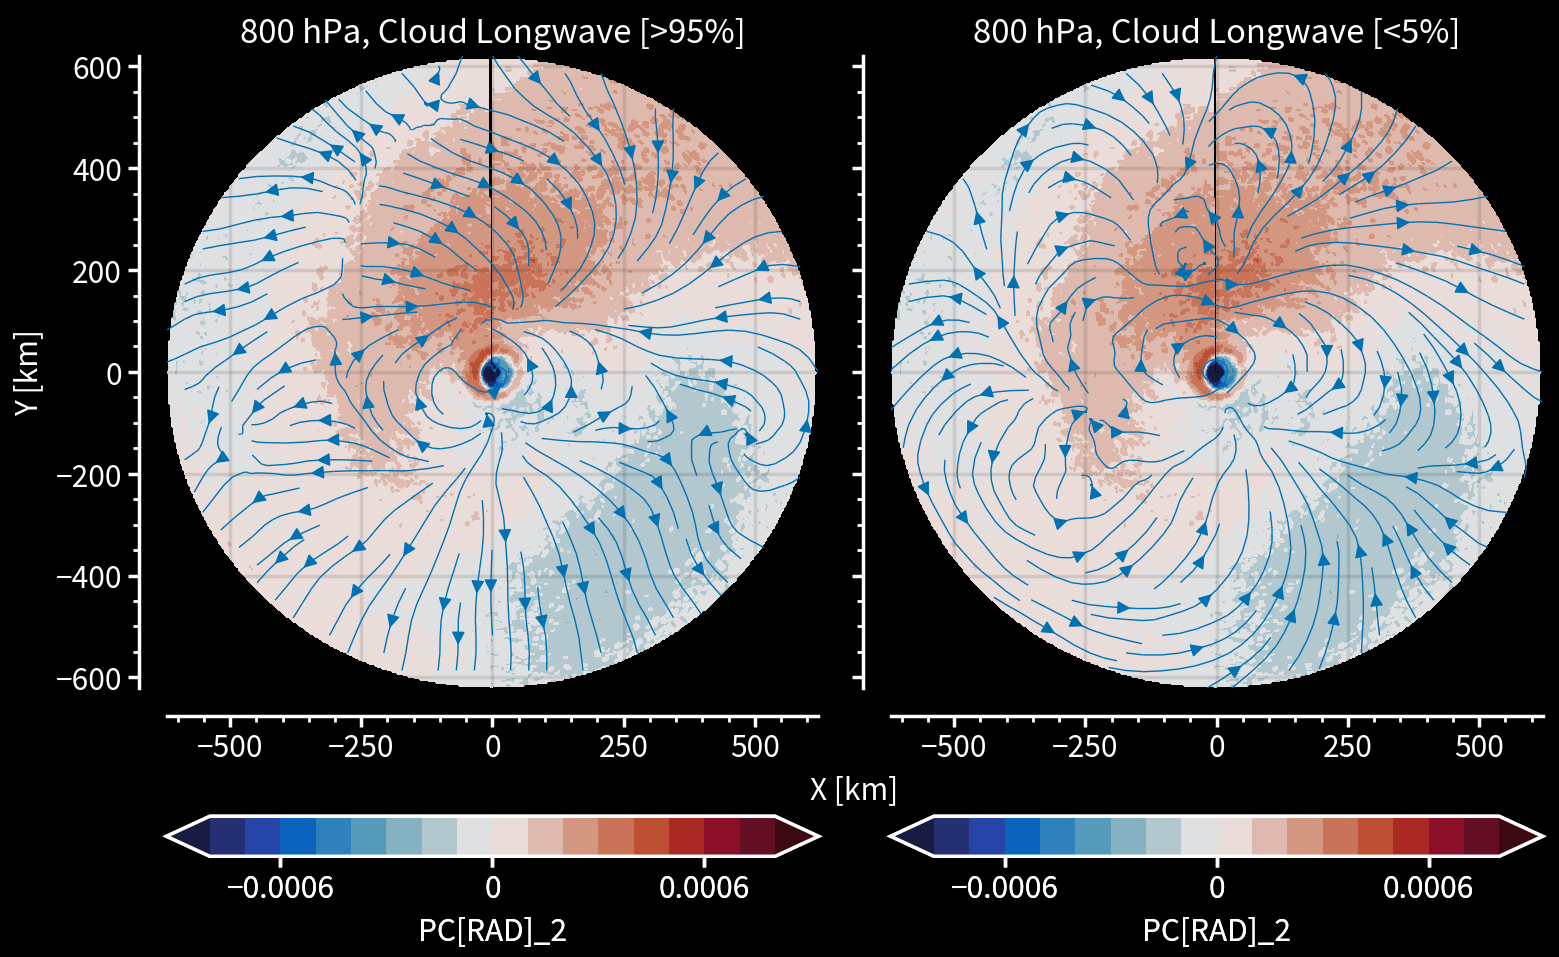

In [195]:
ut,vt = [u95,u5],[v95,v5]
fig, axs = plot.subplots(ncols=2,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)')
typelabel=['Cloud Longwave [>95%]','Cloud Longwave [<5%]']#['Cloud Longwave [>95%]','Cloud Longwave [<5%]']
for indices in range(2):
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
                          np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(PCAdict['rad'].components_[1,:].reshape(10,360,208)[2,:,:],ANGLE,True,False)))),0),\
                         cmap='balance',levels=np.linspace(-0.0008,0.0008,17),colorbar='b',colorbar_kw={'format':'simple','ticks':0.0006,'label': 'PC[RAD]_2'},extend='both')
    axs[indices].streamplot(np.linspace(-207,207,416)*3,np.linspace(-207,207,416)*3,ut[indices],vt[indices], density=[1.25, 1.25],linewidth=0.5)
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'{800} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
plt.savefig('../figures/0425/MLR_dvdtrecon_decompcheck_24hr_800_95_5_vect.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

/tmp/ipykernel_3330616/3814179497.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})


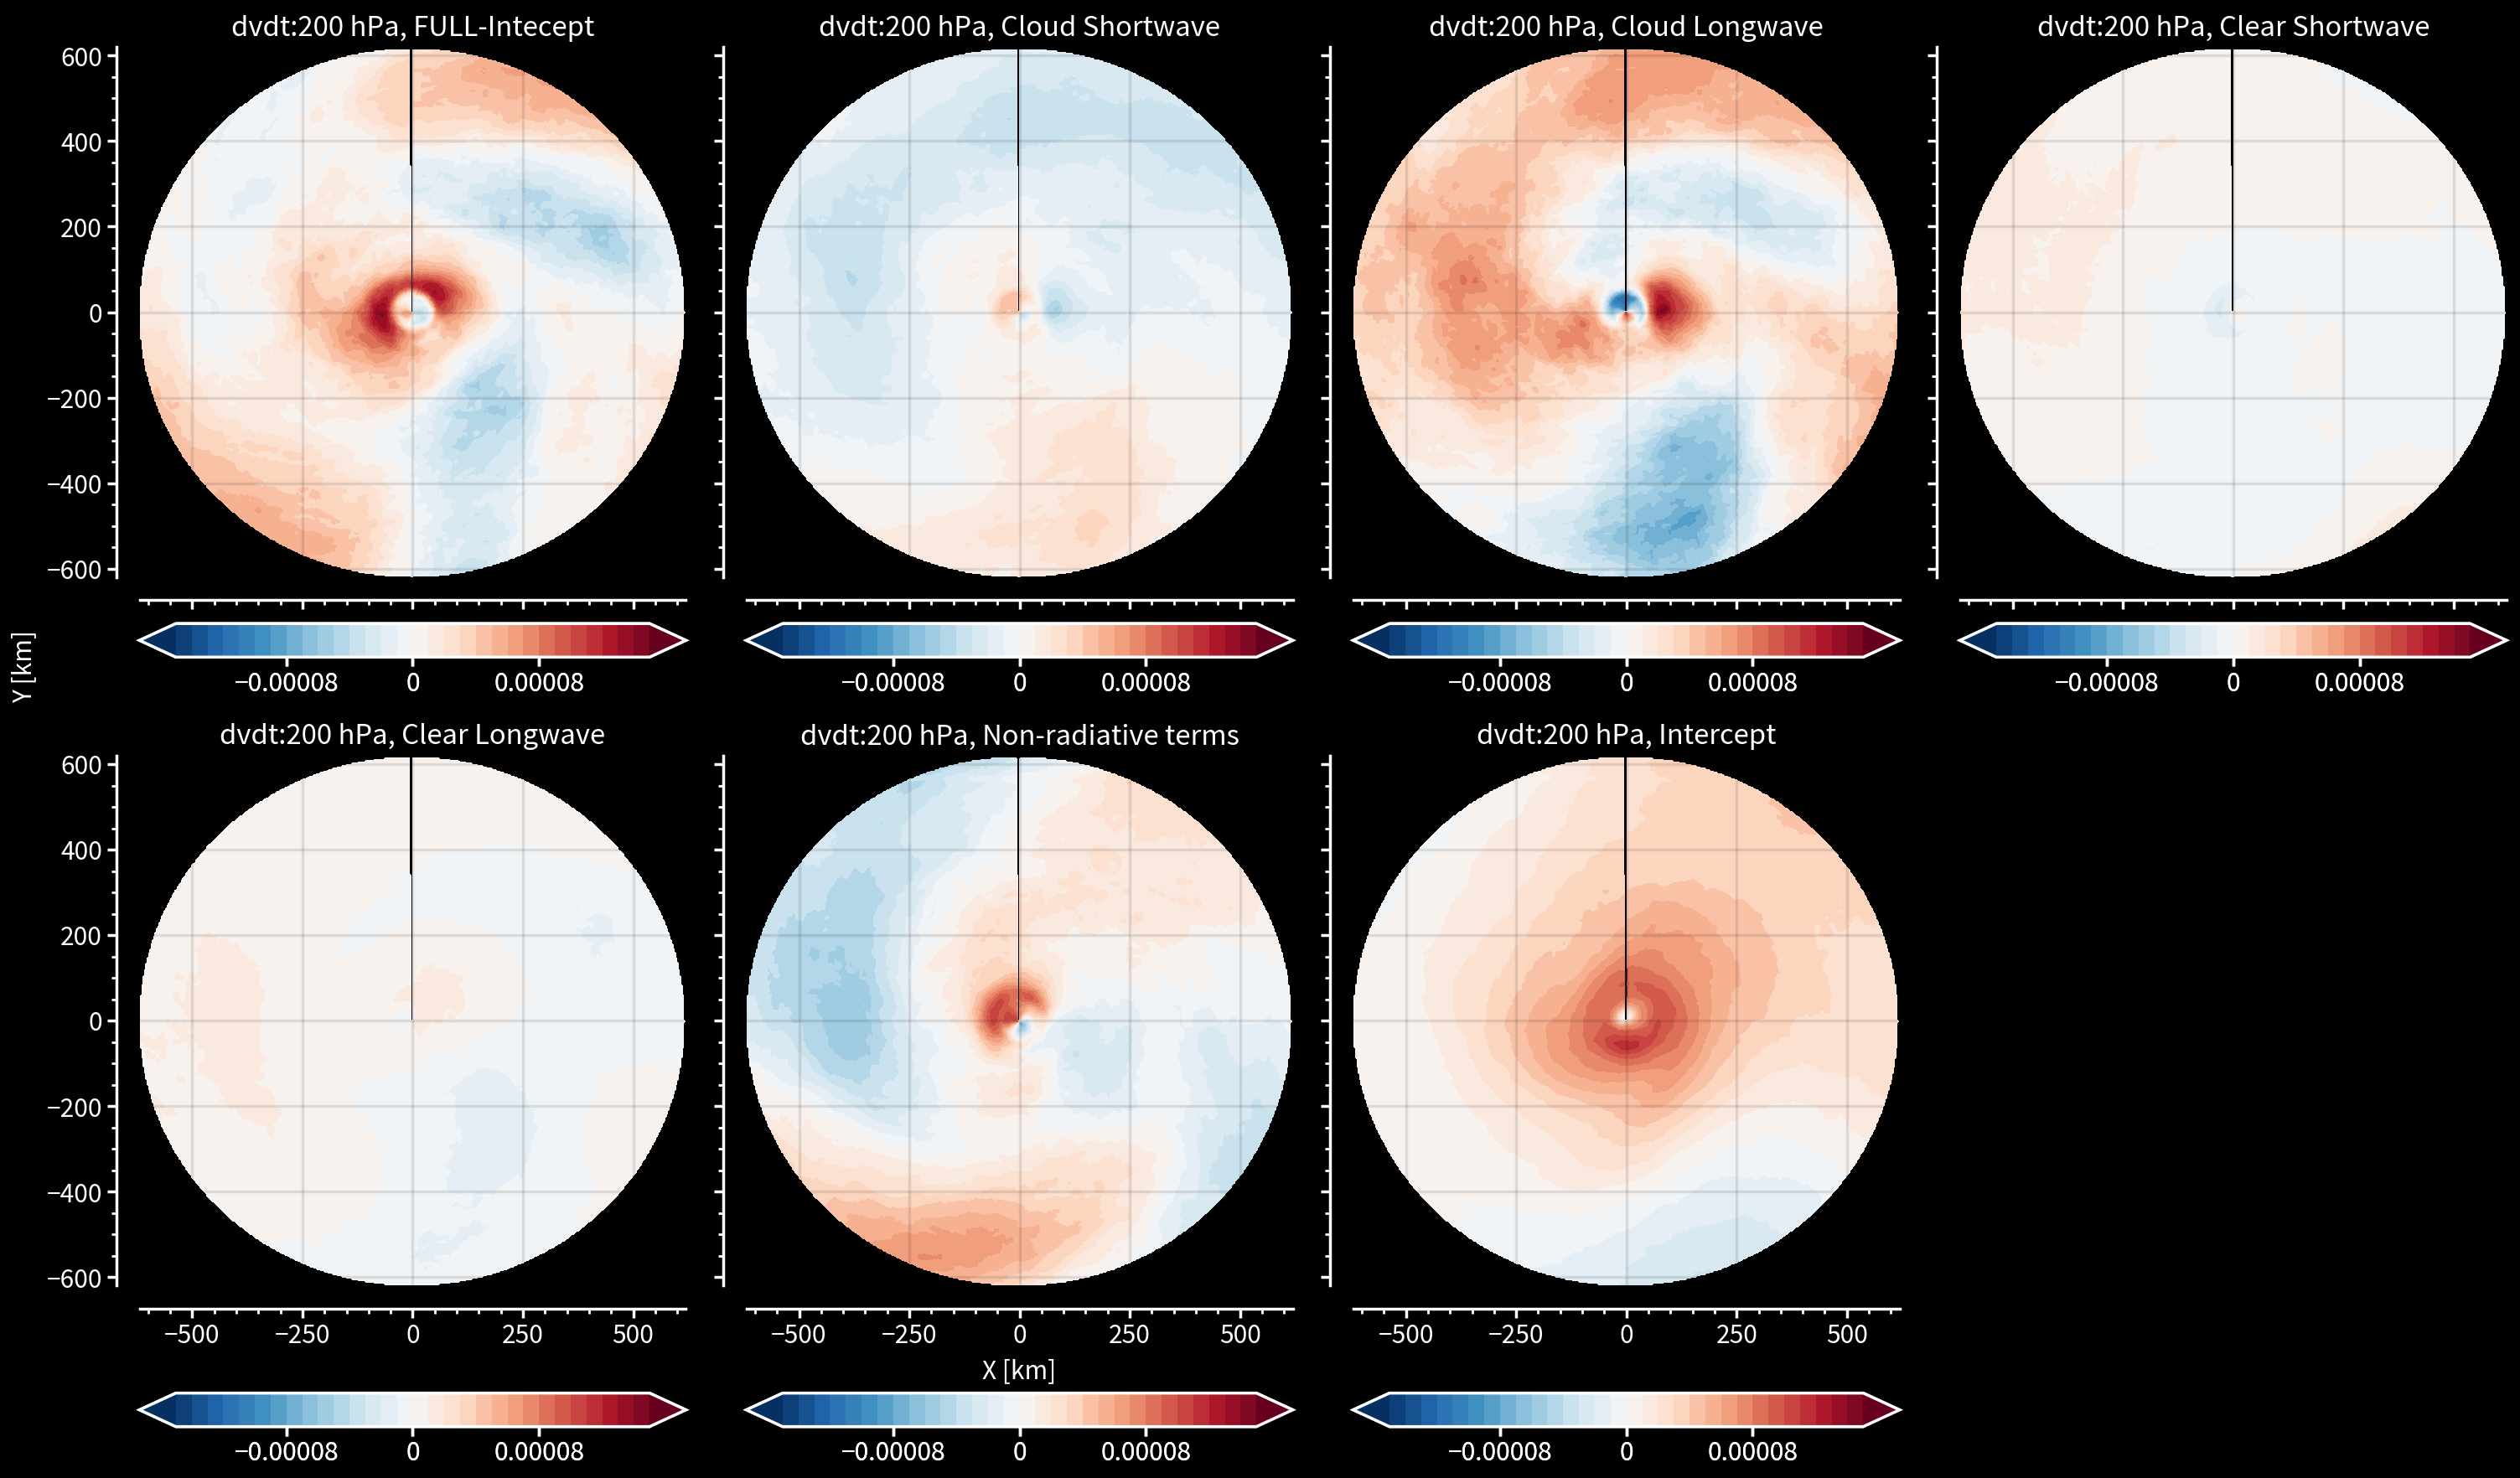

In [22]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

smpl = 406
y = [ np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full-dvdt_b).reshape(dvdt_sw.shape[0],10,360,208))[smpl,8,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart((dvdt_irsw.reshape(dvdt_sw.shape[0],10,360,208))[smpl,8,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart((dvdt_irlw.reshape(dvdt_sw.shape[0],10,360,208))[smpl,8,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart((dvdt_clearsw.reshape(dvdt_sw.shape[0],10,360,208))[smpl,8,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart((dvdt_clearlw.reshape(dvdt_sw.shape[0],10,360,208))[smpl,8,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_extra).reshape(dvdt_sw.shape[0],10,360,208))[smpl,8,...],ANGLE,True,False)))),
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_b).reshape(dvdt_sw.shape[0],10,360,208))[smpl,8,...],ANGLE,True,False))))]

typelabel=['FULL-Intecept','Cloud Shortwave','Cloud Longwave','Clear Shortwave','Clear Longwave','Non-radiative terms','Intercept']

fig, axs = plot.subplots(ncols=4,nrows=2,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)')
for indices in range(7):
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-15e-5,15e-5,31),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00008},extend='both')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{200} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
axs[7].set_visible(False)
plt.savefig('../figures/0425/MLR_dvdtrecon_decompcheck_24hr_200_example.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

/tmp/ipykernel_691487/3646237798.py:5: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})


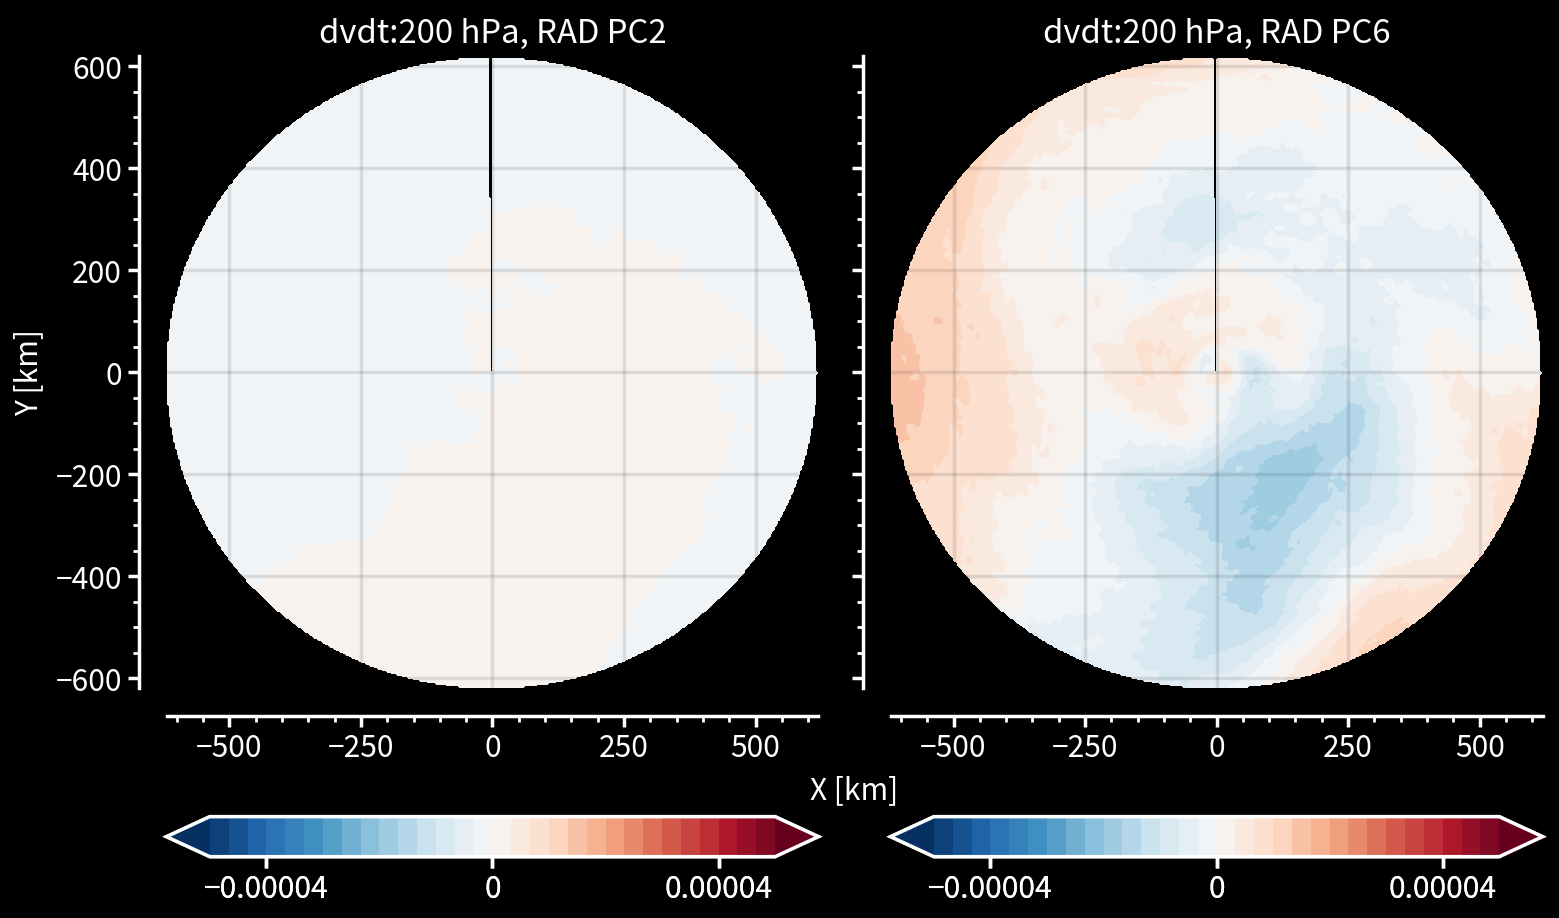

In [35]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))

plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'
smpl = 406
y = [ #np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full).reshape(dvdt_full.shape[0],10,360,208))[smpl,2,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart((prediction_to_cartesian_single(model[5],reducedX[5],None,[10,360,208],'alluv',19)[1].reshape(dvdt_radpc2.shape[0],10,360,208))[smpl,8,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart((prediction_to_cartesian_single(model[5],reducedX[5],None,[10,360,208],'alluv',15)[1].reshape(dvdt_radpc6.shape[0],10,360,208))[smpl,8,...],ANGLE,True,False))))]

typelabel=['RAD PC2','RAD PC6']

fig, axs = plot.subplots(ncols=2,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)')
for indices in range(2):
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-5e-5,5e-5,31),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00004},extend='both')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{200} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
plt.savefig('../figures/0406/MLR_dvdtrecon_decompPC_24hr_200.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

/tmp/ipykernel_696136/2764959830.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})


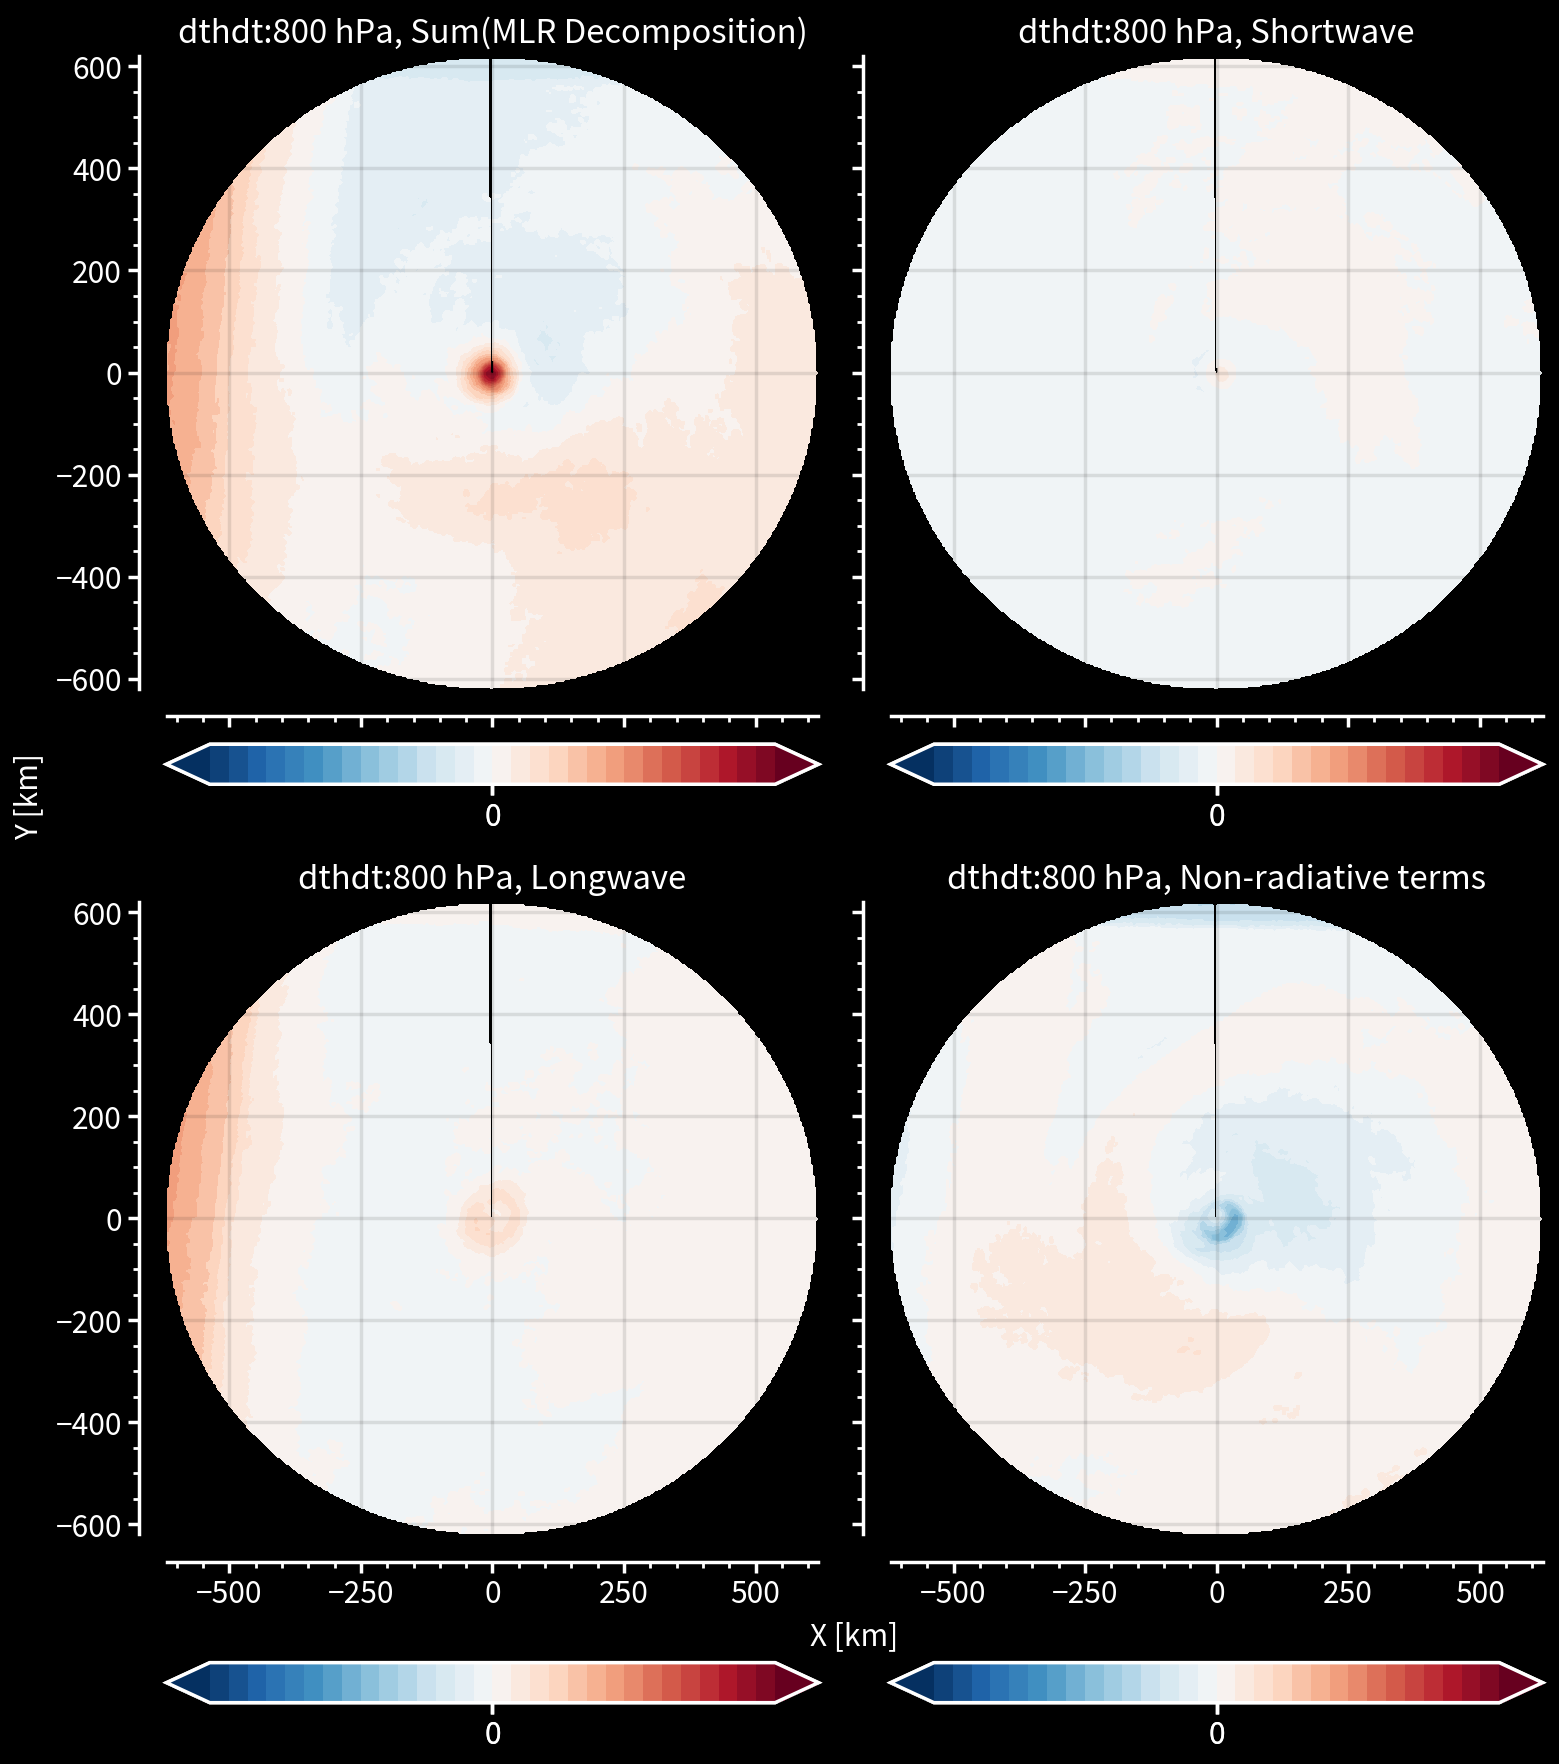

In [16]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

smpl = 406
y = [ np.fliplr(np.flipud((read_and_proc.proc_tocart(((dthdt_extra+dthdt_b+dthdt_lw+dthdt_sw).reshape(dthdt_sw.shape[0],10,360,208))[smpl,4,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart((dthdt_sw.reshape(dthdt_sw.shape[0],10,360,208))[smpl,4,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart((dthdt_lw.reshape(dthdt_sw.shape[0],10,360,208))[smpl,4,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart(((dthdt_extra).reshape(dthdt_sw.shape[0],10,360,208))[smpl,4,...],ANGLE,True,False))))]

typelabel=['Sum(MLR Decomposition)','Shortwave','Longwave','Non-radiative terms']

fig, axs = plot.subplots(ncols=2,nrows=2,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)')
for indices in range(4):
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-5e-5,5e-5,31),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00008},extend='both')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'dthdt:{800} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
#plt.savefig('../figures/0406/MLR_dthdtrecon_decompcheck_24hr_800.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

#### Selective sampling

In [43]:
import pandas as pd
fullsurfwinds = (np.sqrt(dudt_full**2+dvdt_full**2).reshape(dudt_full.shape[0],10,360,208))[:,0,...]
maxtimesamples = np.max(fullsurfwinds,axis=(1,2))

df = pd.DataFrame(maxtimesamples,columns=['maxwindspeeds'])
percent95_indices = list(df[df['maxwindspeeds']>np.percentile(df['maxwindspeeds'],95)].index)

def avg_subsample(array=None,arrayref=None,index=None,vertlv=None):
    temp = [np.fliplr(np.flipud((read_and_proc.proc_tocart((array.reshape(arrayref.shape[0],10,360,208))[index[smpl],vertlv,...],ANGLE,True,False)))) for smpl in tqdm(range(len(index)))]
    return np.mean(np.asarray(temp),axis=0)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

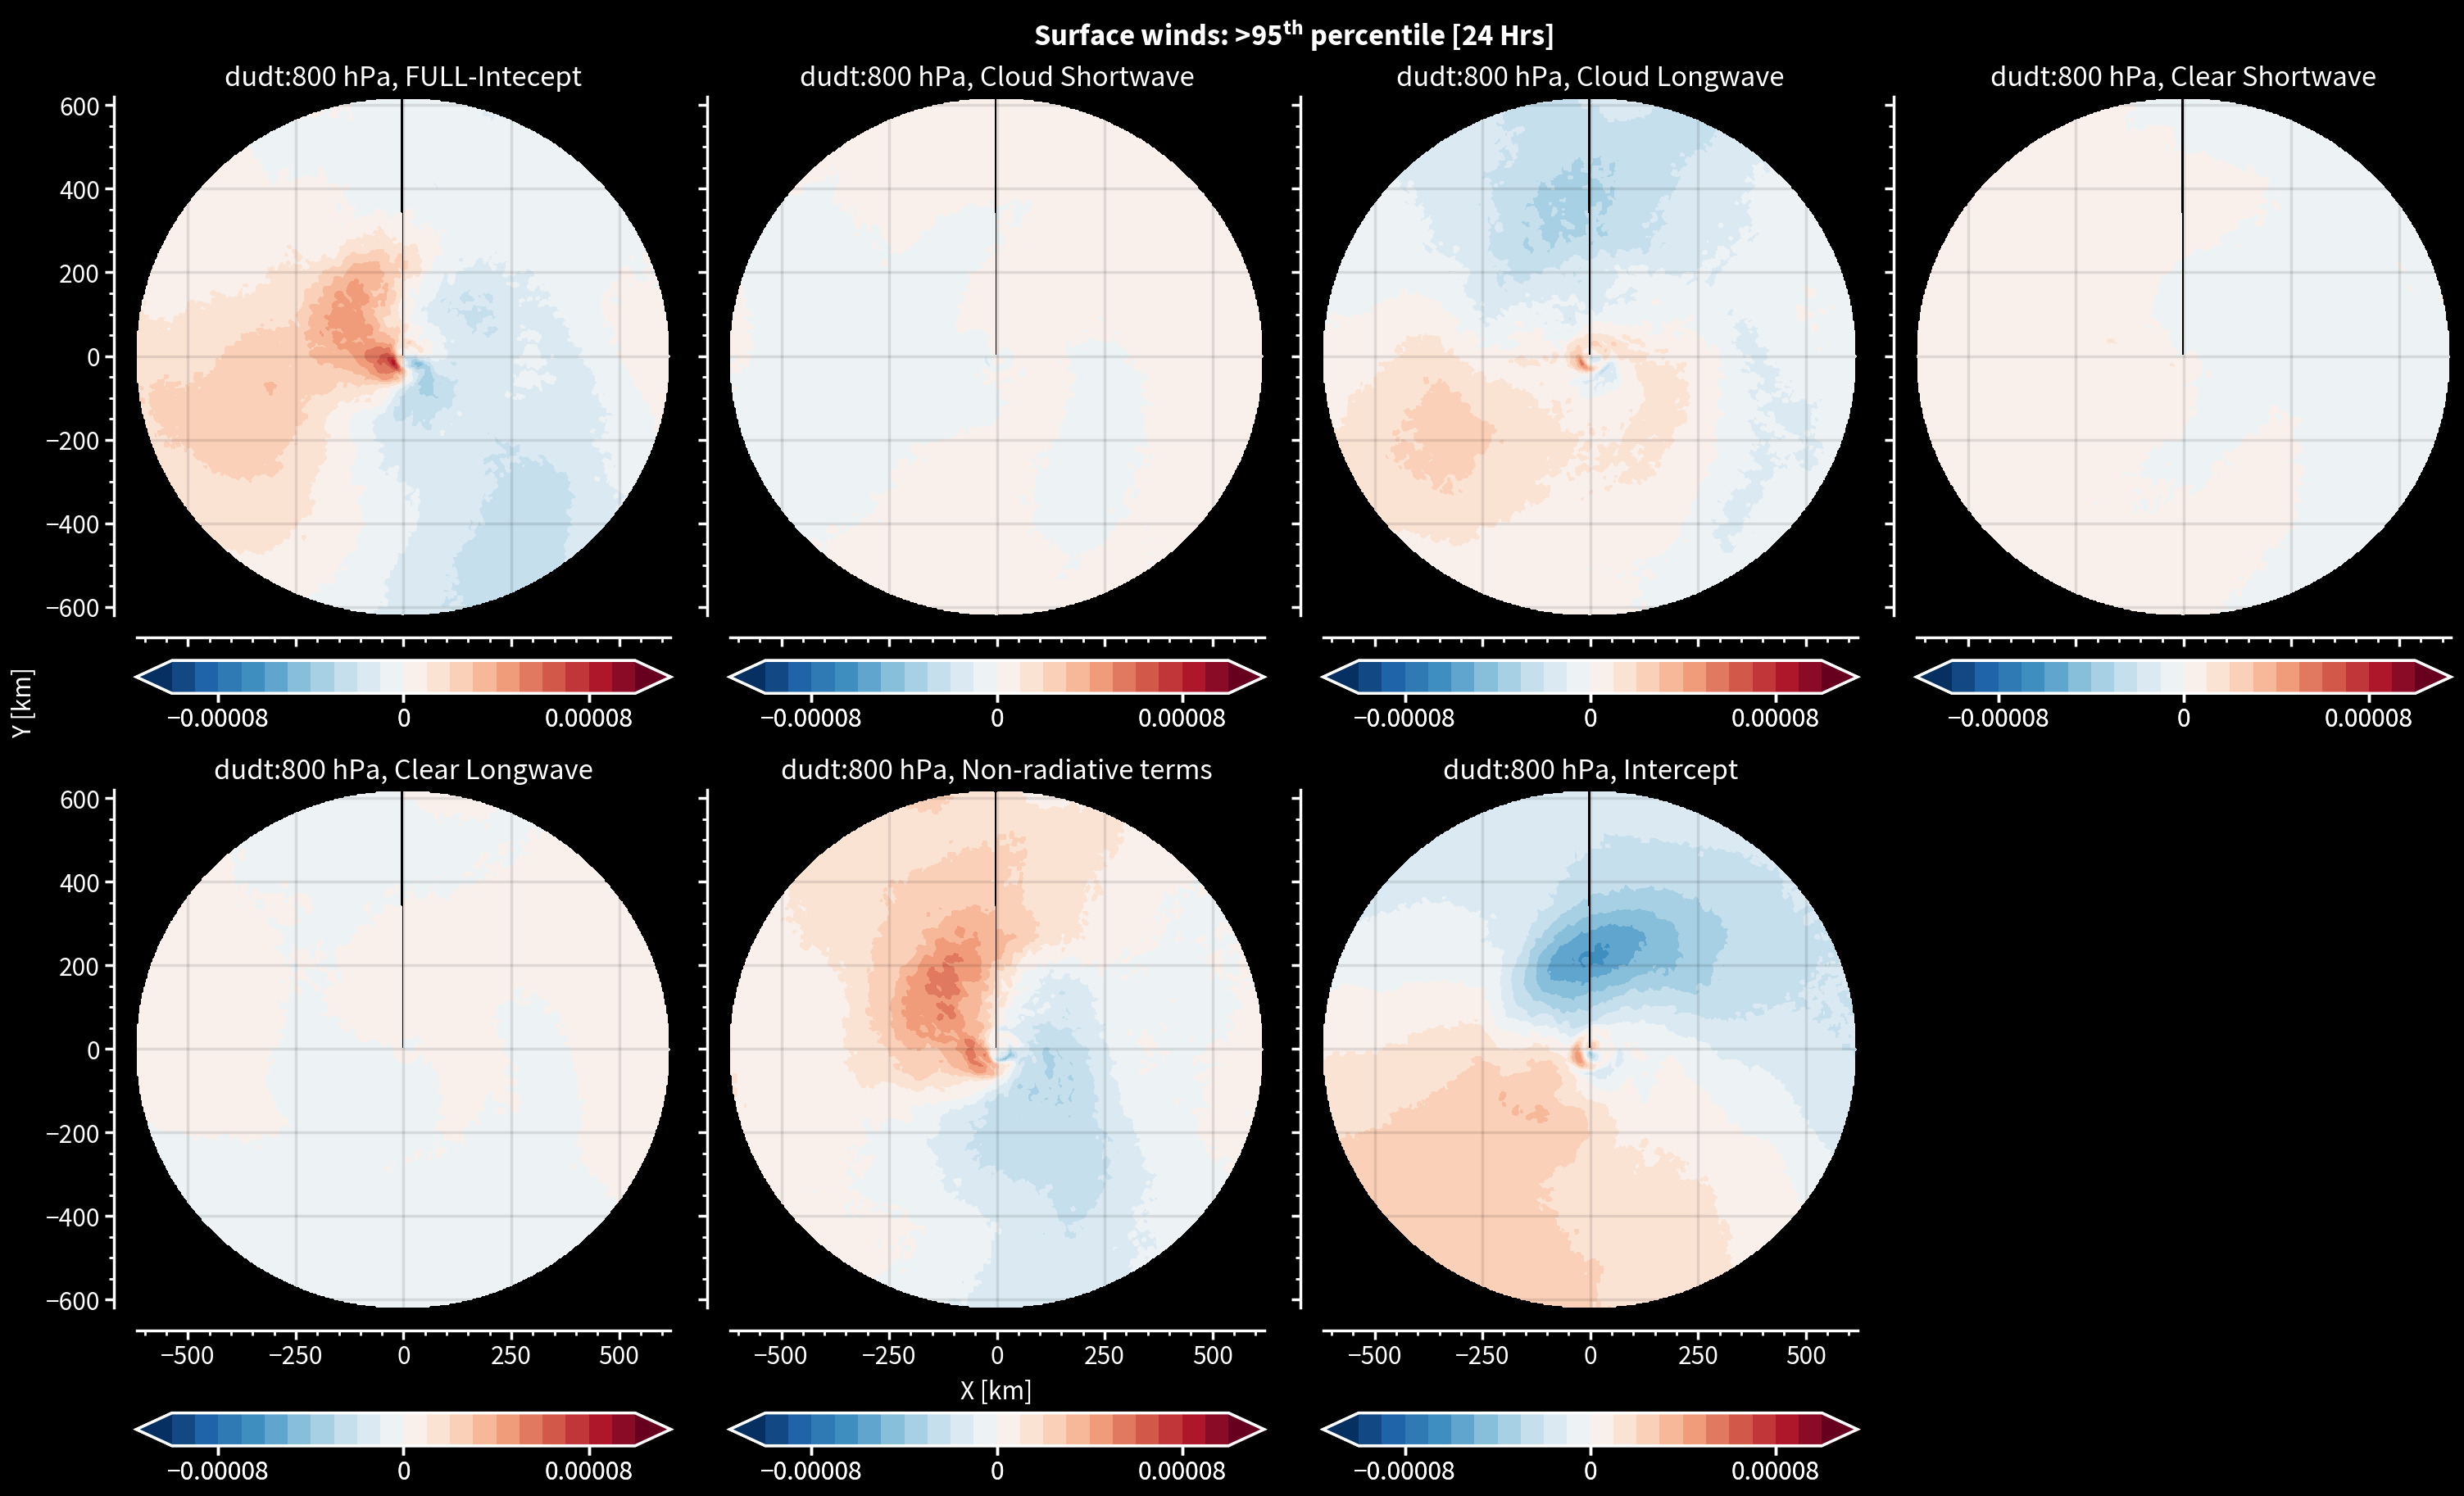

In [44]:
percent95_indices = list(df[df['maxwindspeeds']>np.percentile(df['maxwindspeeds'],95)].index)
hlv=2
y = [ avg_subsample((dudt_full-dudt_b),dudt_lw,percent95_indices,hlv),avg_subsample((dudt_irsw),dudt_lw,percent95_indices,hlv),avg_subsample((dudt_irlw),dudt_lw,percent95_indices,hlv),\
    avg_subsample((dudt_clearsw),dudt_lw,percent95_indices,hlv),avg_subsample((dudt_clearlw),dudt_lw,percent95_indices,hlv),avg_subsample((dudt_extra),dudt_lw,percent95_indices,hlv),avg_subsample((dudt_b),dudt_lw,percent95_indices,hlv)]
typelabel=['FULL-Intecept','Cloud Shortwave','Cloud Longwave','Clear Shortwave','Clear Longwave','Non-radiative terms','Intercept']
var='u'

fig, axs = plot.subplots(ncols=4,nrows=2,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Surface winds: >95$^{th}$ percentile [24 Hrs]')
for indices in range(7):
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-10e-5,10e-5,21),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00008},extend='both') #v: np.linspace(-15e-5,15e-5,31) #u: np.linspace(-10e-5,10e-5,21),dth: (-5e-5,5e-5,21; 0.00008
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'd'+str(var)+f'dt:{800} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
axs[7].set_visible(False)
plt.savefig('../figures/0425/MLR_d'+str(var)+'dtrecon_decompcheck_24hr_95percent_800.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

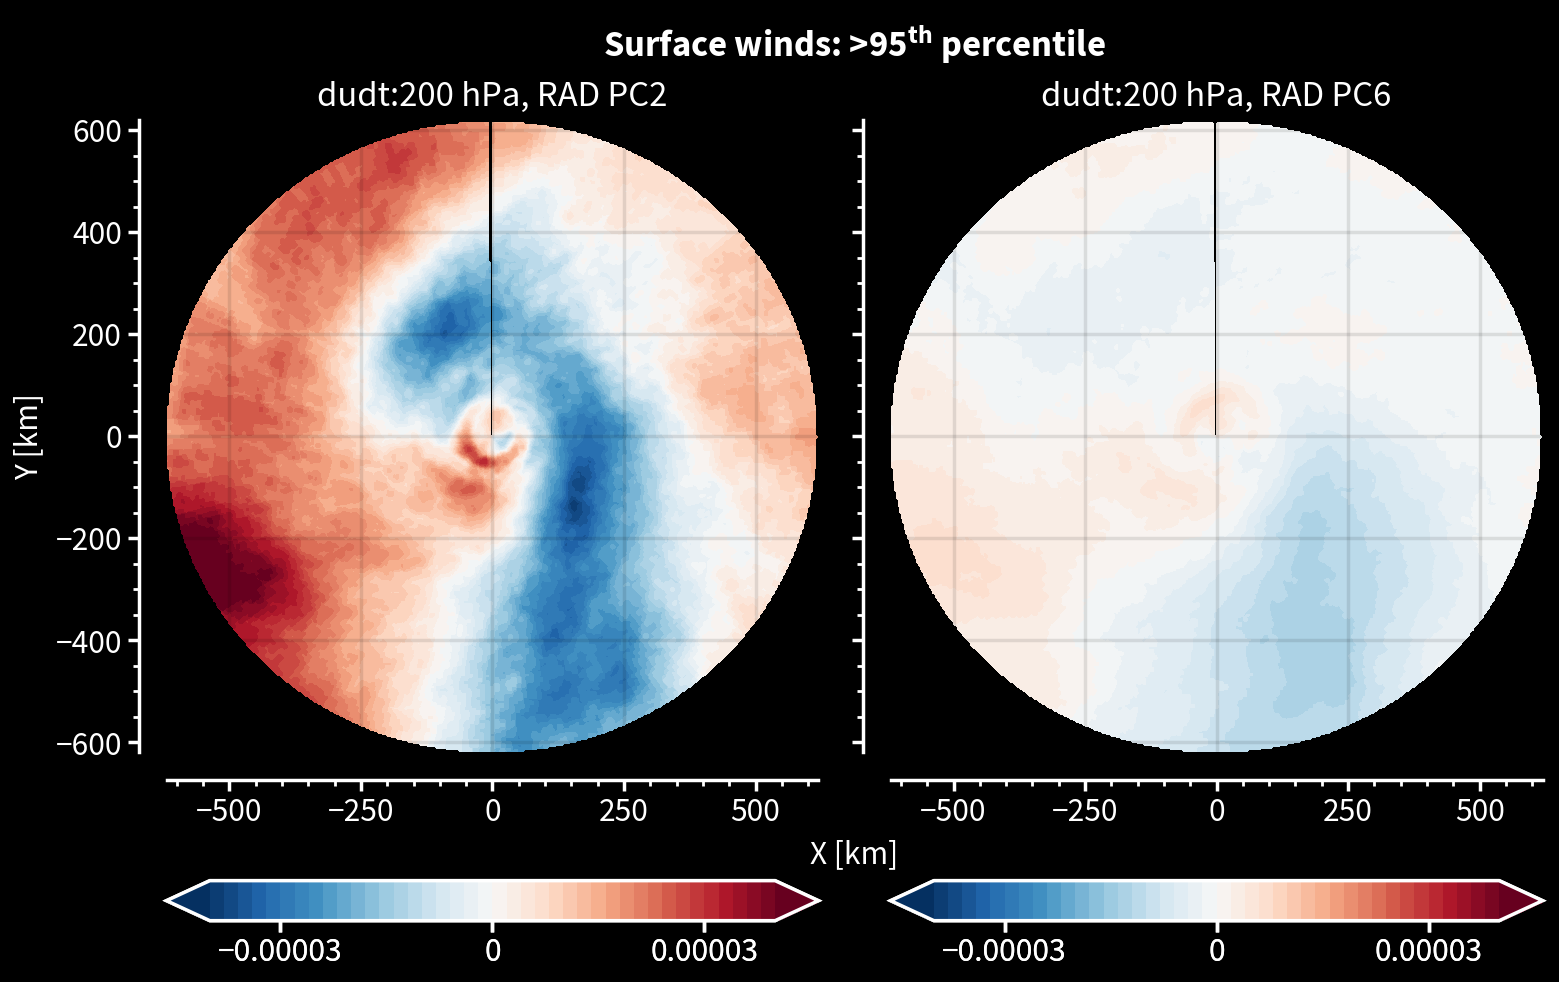

In [46]:
percent95_indices = list(df[df['maxwindspeeds']>np.percentile(df['maxwindspeeds'],95)].index)
y = [ avg_subsample((dudt_radpc2),dudt_lw,percent95_indices,8),avg_subsample((dudt_radpc6),dudt_lw,percent95_indices,8)]#,\
#    avg_subsample((dudt_lw),dudt_lw,percent95_indices),avg_subsample((dudt_extra),dudt_lw,percent95_indices)]

typelabel=['RAD PC2','RAD PC6']
var = 'u'
fig, axs = plot.subplots(ncols=2,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Surface winds: >95$^{th}$ percentile')
for indices in range(2):
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-4e-5,4e-5,41),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00003},extend='both') #v: np.linspace(-15e-5,15e-5,31)
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'd'+str(var)+f'dt:{200} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
plt.savefig('../figures/0406/MLR_d'+str(var)+'dtrecon_decompPC_24hr_95percent_200.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

#### Test FFT-based heat decomposition

In [213]:
def FFT_subsample(array=None,arrayref=None,index=None,vertlv=None):
    output = []
    for i in tqdm(range(10)):
        temp = np.asarray([np.fliplr(np.flipud((read_and_proc.proc_tocart((array.reshape(arrayref.shape[0],10,360,208))[index[smpl],i,...],ANGLE,True,False)))) for smpl in (range(len(index)))])
        output.append(temp)#np.mean(temp,axis=0))
    return output
#percent95_indices = list(df[df['maxwindspeeds']<np.percentile(df['maxwindspeeds'],5)].index)
heat_to_FFT = [FFT_subsample((dthdt_full),dthdt_lw,percent95_indices), FFT_subsample((dthdt_lw),dthdt_lw,percent95_indices), FFT_subsample((dthdt_full-dthdt_b),dthdt_lw,percent95_indices)]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [201]:
testt = avg_subsample((dthdt_extra+dthdt_b+dthdt_lw+dthdt_sw),dthdt_lw,percent95_indices,8)

  0%|          | 0/44 [00:00<?, ?it/s]

In [202]:
def test_convstrat(fftmag=None):
    from copy import deepcopy
    temp = np.fft.fft(np.asarray(fftmag),n=20,axis=1).real
    conv,strat,shal = np.abs(np.ma.masked_less(deepcopy(temp[:,1,:,:]),0)),np.abs(np.ma.masked_greater(deepcopy(temp[:,2,:,:]),0)),np.abs(np.ma.masked_less(deepcopy(temp[:,3,:,:]),0))
    conv.filled(np.nan)
    strat.filled(np.nan)
    shal.filled(np.nan)
    #convt,stratt,shalt = [(conv[i]-np.nanmean(conv[i]))/np.nanstd(conv[i]) for i in range(conv.shape[0])],[(strat[i]-np.nanmean(strat[i]))/np.nanstd(strat[i]) for i in range(conv.shape[0])],[(shal[i]-np.nanmean(shal[i]))/np.nanstd(shal[i]) for i in range(conv.shape[0])]
    convf = np.asarray(conv).flatten()
    stratf = np.asarray(strat).flatten()
    shalf = np.asarray(shal).flatten()
    
    ans = []
    for i in tqdm(range(len(convf))):
        temp = np.asarray([convf[i],stratf[i],shalf[i]])
        if (np.all((temp==0))):
            ans.append(np.nan)
        else:
            ans.append(temp.argmax()+1)
    return np.asarray(ans).reshape(conv.shape)

In [200]:
testans = test_convstrat(fftmag=heat_to_FFT[0])

  0%|          | 0/7614464 [00:00<?, ?it/s]

In [208]:
np.asarray(heat_to_FFT).shape

(3, 44, 416)

In [203]:
index = 4
y = [ np.ma.masked_less(np.ma.masked_where(testt<0,np.nanmean((np.fft.fft(np.asarray(heat_to_FFT[1]),n=20,axis=1).real)[1,:,:],axis=0)),0),\
    np.ma.masked_greater(np.ma.masked_where(testt<0,np.nanmean((np.fft.fft(np.asarray(heat_to_FFT[1]),n=20,axis=1).real)[2,:,:],axis=0)),0),\
    np.ma.masked_less(np.ma.masked_where(testt<0,np.nanmean((np.fft.fft(np.asarray(heat_to_FFT[1]),n=20,axis=1).real)[3,:,:],axis=0)),0)]#,\
#    avg_subsample((dudt_lw),dudt_lw,percent95_indices),avg_subsample((dudt_extra),dudt_lw,percent95_indices)]

typelabel=['Wavenumber=1','Wavenumber=2','Wavenumber=3']
cmap = ['magma','magma_r','magma']
var = 'theta'
fig, axs = plot.subplots(ncols=3,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Surface winds: >95$^{th}$ percentile')
for indices in range(3):
    axs[indices].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(y[indices],0),\
                            cmap=cmap[indices],colorbar='b',extend='both')#colorbar_kw={'format':'simple','ticks':0.00003},extend='both') #v: np.linspace(-15e-5,15e-5,31)
    axs[indices].streamplot(np.linspace(-207,207,416)*3,np.linspace(-207,207,416)*3,ut[indices],vt[indices], density=[1.25, 1.25],linewidth=0.5,color='yellow')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=r'FFT$_{v,\theta}$'+f': {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
#plt.savefig('../figures/0406/MLR_d'+str(var)+'dtrecon_fftv_24hr_95percent.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

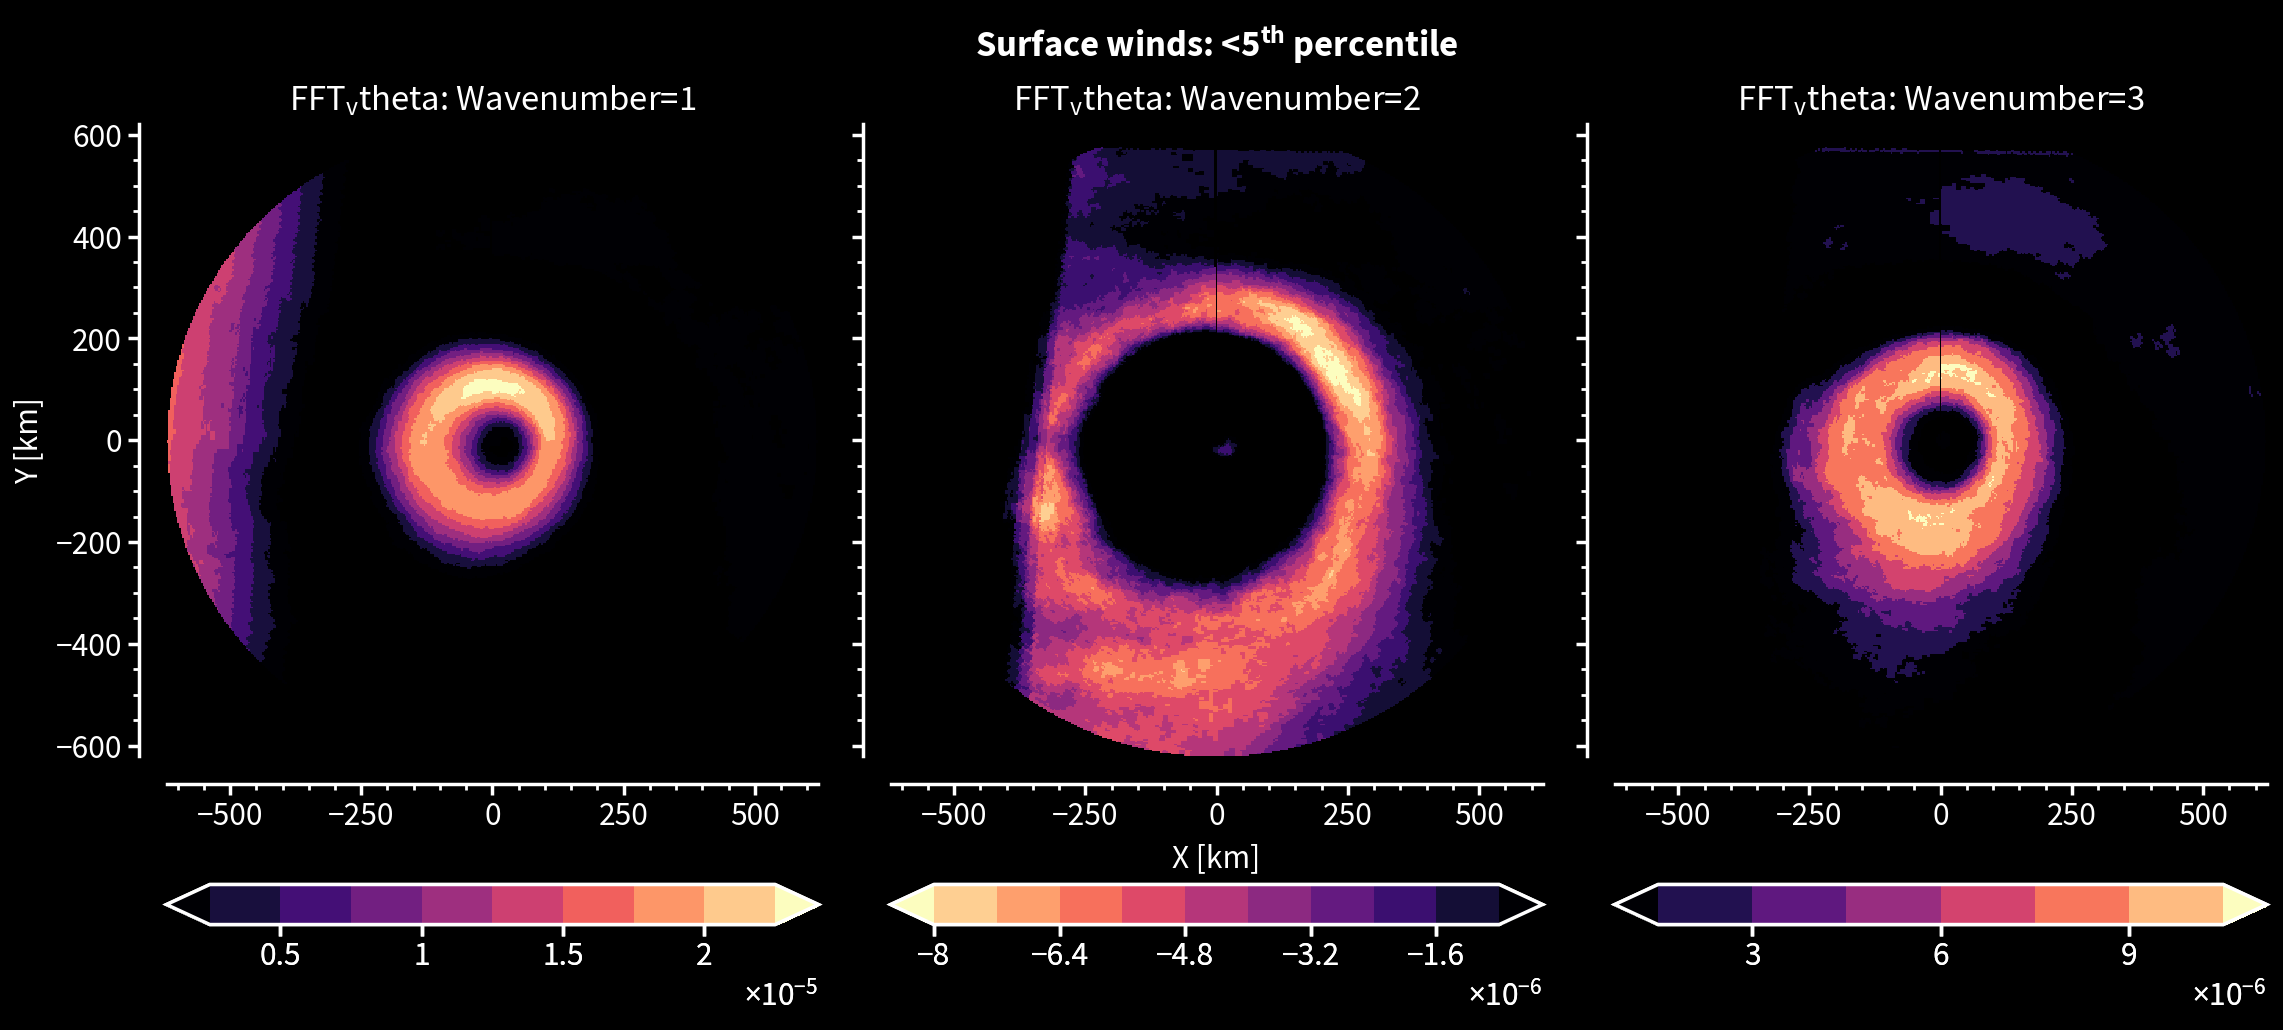

In [237]:
index = 4
y = [ np.ma.masked_less(np.ma.masked_where(testt<0,np.nanmean((np.fft.fft(np.asarray(heat_to_FFT[1]),n=20,axis=1).real)[1,:,:],axis=0)),0),\
    np.ma.masked_greater(np.ma.masked_where(testt<0,np.nanmean((np.fft.fft(np.asarray(heat_to_FFT[1]),n=20,axis=1).real)[2,:,:],axis=0)),0),\
    np.ma.masked_less(np.ma.masked_where(testt<0,np.nanmean((np.fft.fft(np.asarray(heat_to_FFT[1]),n=20,axis=1).real)[3,:,:],axis=0)),0)]#,\
#    avg_subsample((dudt_lw),dudt_lw,percent95_indices),avg_subsample((dudt_extra),dudt_lw,percent95_indices)]

typelabel=['Wavenumber=1','Wavenumber=2','Wavenumber=3']
cmap = ['magma','magma_r','magma']
var = 'theta'
fig, axs = plot.subplots(ncols=3,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Surface winds: <5$^{th}$ percentile')
for indices in range(3):
    axs[indices].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(y[indices],0),\
                            cmap=cmap[indices],colorbar='b',extend='both')#colorbar_kw={'format':'simple','ticks':0.00003},extend='both') #v: np.linspace(-15e-5,15e-5,31)
    axs[indices].streamplot(np.linspace(-207,207,416)*3,np.linspace(-207,207,416)*3,ut[indices],vt[indices], density=[1.25, 1.25],linewidth=0.5,color='yellow')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=r'FFT$_{v}$'+str(var)+f': {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
#plt.savefig('../figures/0406/MLR_d'+str(var)+'dtrecon_decompPC_24hr_95percent_200.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

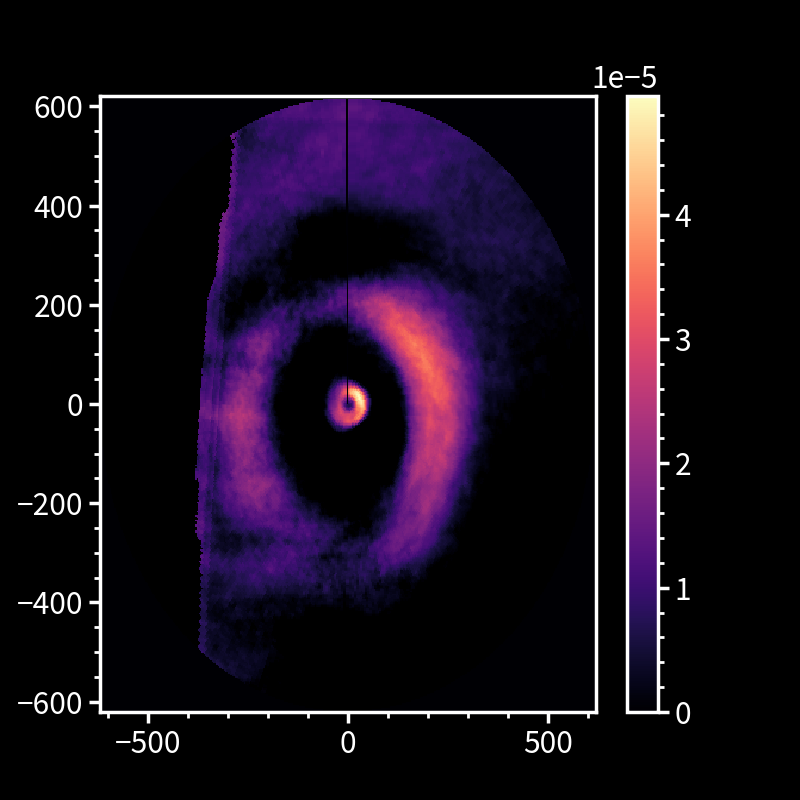

In [227]:
#img = plt.pcolormesh(np.ma.masked_less(np.fft.fft(np.asarray(heat_to_FFT[0]),n=20,axis=1).real,0)[4,1,:,:],cmap='magma')#,vmax=0.0004)
img = plt.pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_less(np.ma.masked_where(testt<0,(np.fft.fft(np.asarray(heat_to_FFT[1]),n=20,axis=1).real)[40,3,:,:]),0),cmap='magma')
#plt.contour(np.ma.masked_where(testt<0,np.abs(np.fft.fft(np.asarray(heat_to_FFT[0]),n=20,axis=0).real)[2,1,:,:]),colors='yellow')#,levels=[0.00005])
plt.colorbar(img)
plt.show()

#### Cross Sections

In [23]:
import pandas as pd
fullsurfwinds = (np.sqrt(dudt_full**2+dvdt_full**2).reshape(869,10,360,208))[:,0,...]
maxtimesamples = np.max(fullsurfwinds,axis=(1,2))

df = pd.DataFrame(maxtimesamples,columns=['maxwindspeeds'])
percent95_indices = list(df[df['maxwindspeeds']<np.percentile(df['maxwindspeeds'],5)].index)

def avg_subsample_profile(array=None,arrayref=None,index=None):
    temp = [array.reshape(arrayref.shape[0],10,360,208)[index[smpl],:,:,:] for smpl in tqdm(range(len(index)))]
    return np.mean(np.mean(np.asarray(temp),axis=0),axis=1)

In [15]:
def output_realdterms(category='train',varnum=2,LT=24):
    if varnum==2:
        a,b,_,_ = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])
        return a,b
    elif varnum==4:
        a,b,c,d = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])     
        return a,b,c,d
lti=24
realdu,realdv,realdw,realdtheta = output_realdterms(category='train',varnum=4,LT=lti)
#realdu_valid,realdv_valid,realdw_valid,realdtheta_valid = output_realdterms(category='valid',varnum=4,LT=lti)
#realdu_test,realdv_test,realdw_test,realdtheta_test = output_realdterms(category='test',varnum=4,LT=lti)

NameError: name 'haiyan_data' is not defined

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

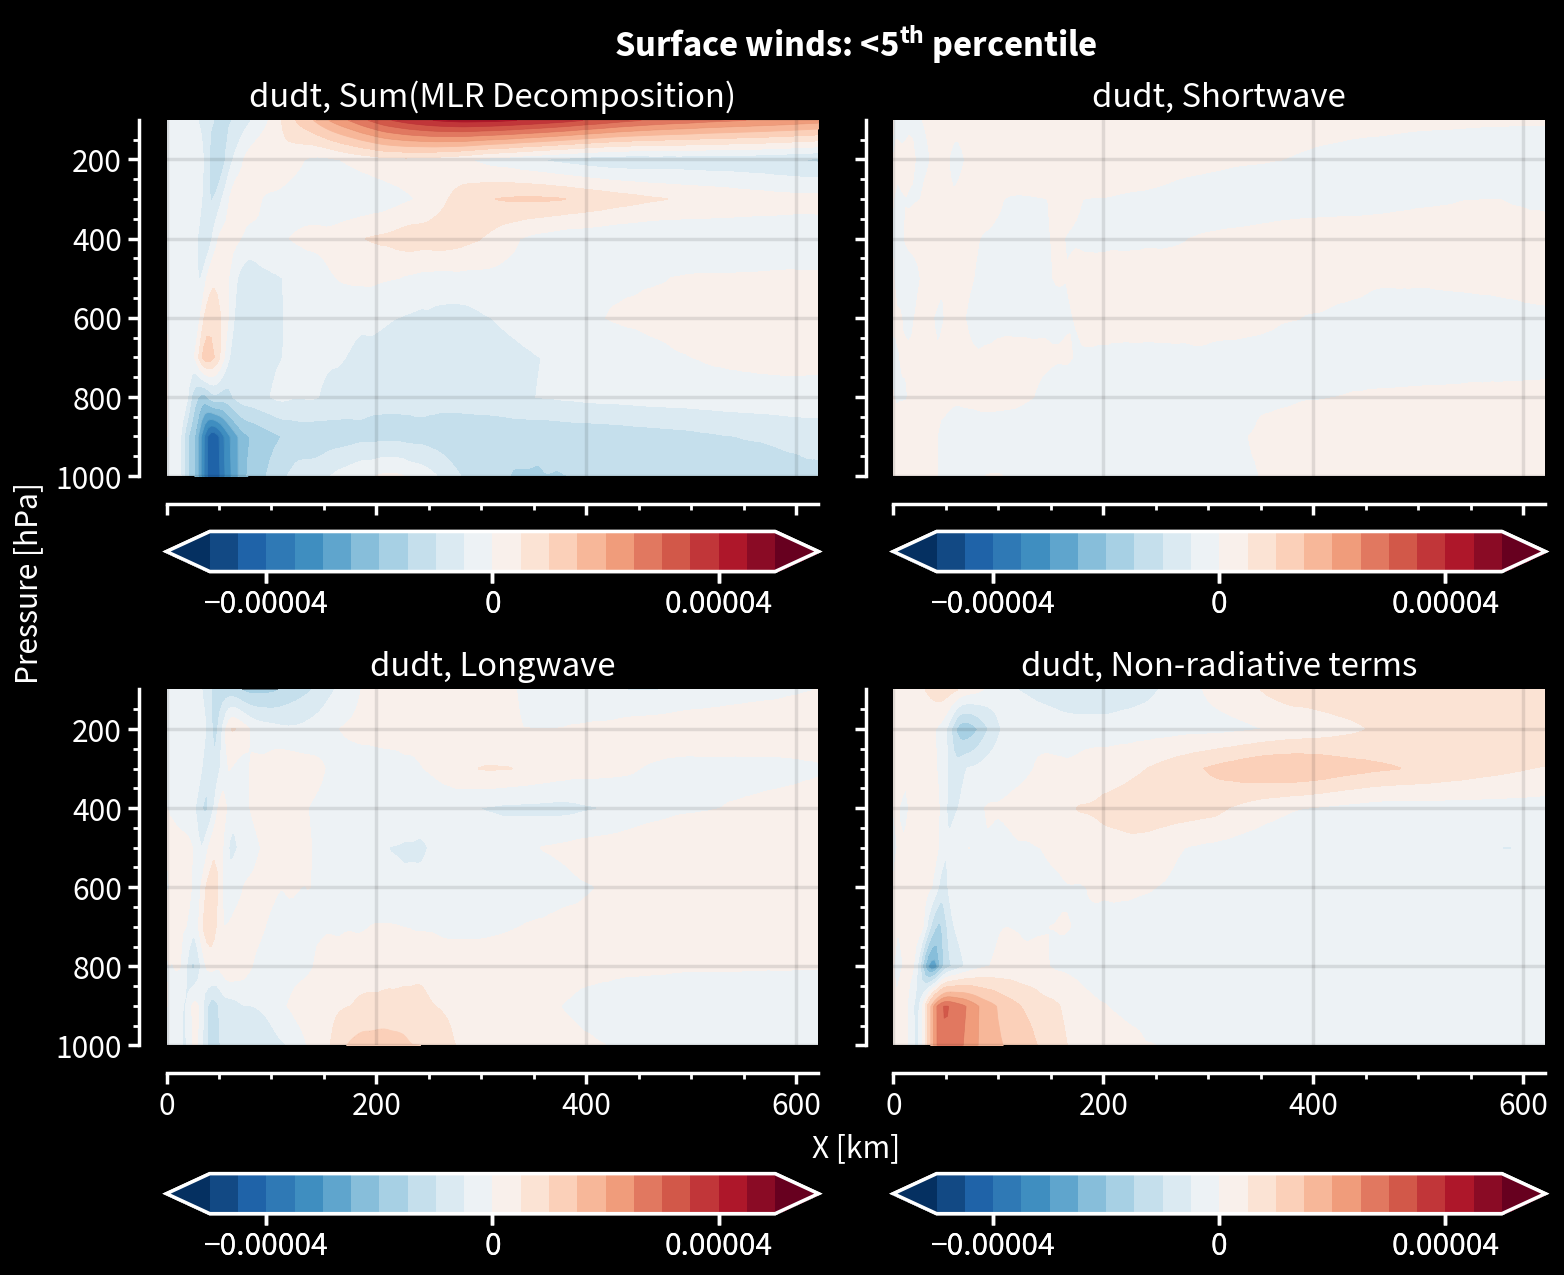

In [37]:
percent95_indices = list(df[df['maxwindspeeds']<np.percentile(df['maxwindspeeds'],5)].index)
y = [ avg_subsample_profile((dudt_extra+dudt_b+dudt_lw+dudt_sw),dudt_lw,percent95_indices),avg_subsample_profile((dudt_sw),dudt_lw,percent95_indices),\
    avg_subsample_profile((dudt_lw),dudt_lw,percent95_indices),avg_subsample_profile((dudt_extra),dudt_lw,percent95_indices)]

typelabel=['Sum(MLR Decomposition)','Shortwave','Longwave','Non-radiative terms']
var='u'
fig, axs = plot.subplots(ncols=2,nrows=2,axwidth=3.2595,refaspect=1.831)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Surface winds: <5$^{th}$ percentile')
for indices in range(4):
    axs[indices].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-5e-5,5e-5,21),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00004},extend='both') #v: np.linspace(-10e-5,10e-5,21)
    axs[indices].format(ylabel='Pressure [hPa]',xlabel='X [km]',title=f'd'+str(var)+f'dt, {typelabel[indices]}',ylim=[1000,100])
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
plt.savefig('../figures/0406/cs/MLR_d'+str(var)+'dtrecon_decompcheck_24hr_5percent.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

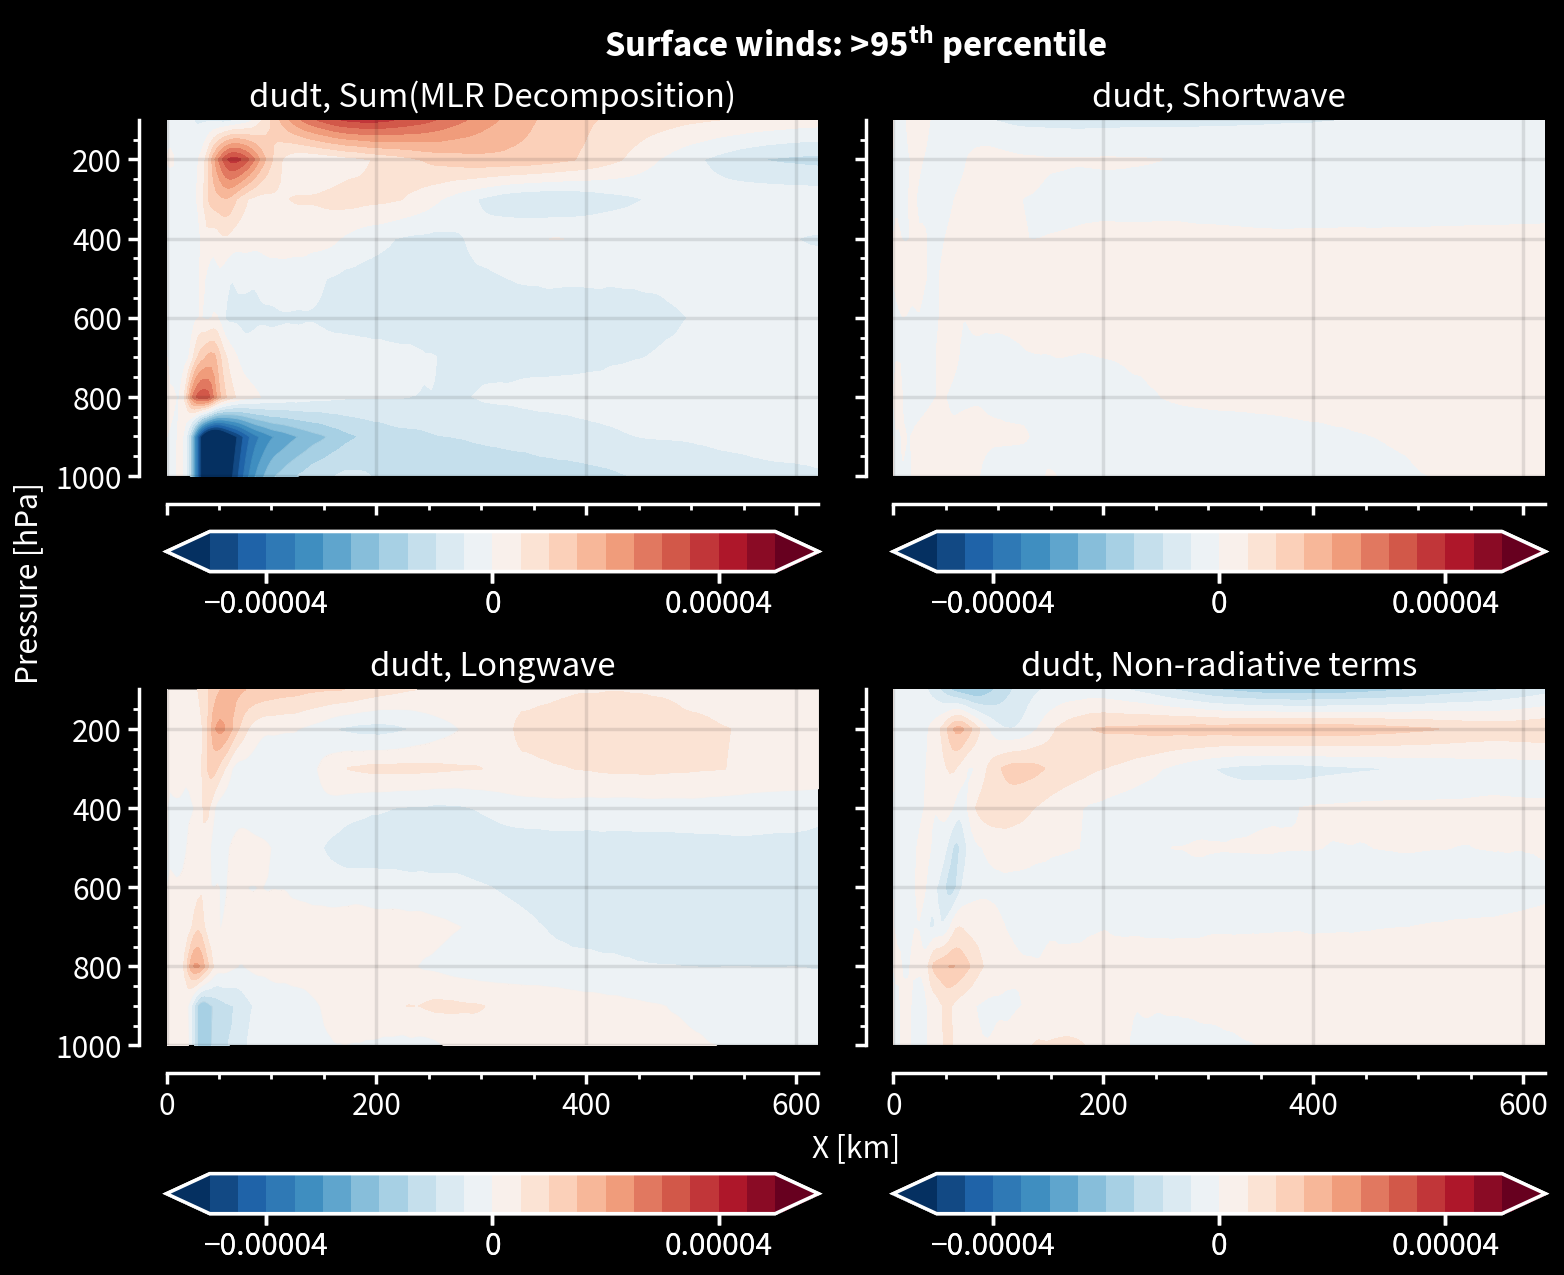

In [38]:
percent95_indices = list(df[df['maxwindspeeds']>np.percentile(df['maxwindspeeds'],95)].index)
y = [ avg_subsample_profile((dudt_extra+dudt_b+dudt_lw+dudt_sw),dudt_lw,percent95_indices),avg_subsample_profile((dudt_sw),dudt_lw,percent95_indices),\
    avg_subsample_profile((dudt_lw),dudt_lw,percent95_indices),avg_subsample_profile((dudt_extra),dudt_lw,percent95_indices)]

typelabel=['Sum(MLR Decomposition)','Shortwave','Longwave','Non-radiative terms']

fig, axs = plot.subplots(ncols=2,nrows=2,axwidth=3.2595,refaspect=1.831)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Surface winds: >95$^{th}$ percentile')
for indices in range(4):
    axs[indices].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-5e-5,5e-5,21),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00004},extend='both') #v: np.linspace(-15e-5,15e-5,31)
    axs[indices].format(ylabel='Pressure [hPa]',xlabel='X [km]',title=f'd'+str(var)+f'dt, {typelabel[indices]}',ylim=[1000,100])
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
plt.savefig('../figures/0406/cs/MLR_dvdtrecon_decompcheck_24hr_95percent.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

#### Structural Similarity

In [12]:
from skimage.metrics import structural_similarity as ssim
def structral_similarity_800hPa(real=None,predict=None):
    real,predict = real.reshape(869,10,360,208)[:,2,:,:],predict.reshape(869,10,360,208)[:,2,:,:]
    a,b = [np.fliplr(np.flipud((proc_tocart(real[i,...],ANGLE,True,False)))) for i in tqdm(range(real.shape[0]))],[np.fliplr(np.flipud((proc_tocart(predict[i,...],ANGLE,True,False)))) for i in tqdm(range(real.shape[0]))]
    return [ssim((a[i]-np.nanmean(a[i]))/(np.nanmax(a[i])-np.nanmin(a[i])),(b[i]-np.nanmean(b[i]))/(np.nanmax(b[i])-np.nanmin(b[i]))) for i in tqdm(range(real.shape[0]))]

In [34]:
def mse_800hPa(real=None,predict=None):
    real,predict = real.reshape(869,10,360,208)[:,2,:,:],predict.reshape(869,10,360,208)[:,2,:,:]
    out1,out2 = [],[]
    for i in tqdm(range(real.shape[0])):
        reala = (real[i,...]-np.nanmean(real[i,...]))/(np.nanmax(real[i,...])-np.nanmin(real[i,...]))
        predicta = (predict[i,...]-np.nanmean(predict[i,...]))/(np.nanmax(predict[i,...])-np.nanmin(predict[i,...]))
        out1.append(np.mean((predict[i,:,0:50]-real[i,:,0:50])**2))
        out2.append(np.mean((predict[i,:,0:50]-real[i,:,50:100])**2))
    return out1,out2
    #return [np.mean((predict[i,:,0:50]-real[i,:,0:50])**2) for i in tqdm(range(real.shape[0]))],[np.mean((predict[i,:,50:100]-real[i,:,50:100])**2) for i in tqdm(range(real.shape[0]))]

##### MSE

In [35]:
inner_mse_wspd,outer_mse_wspd = mse_800hPa(np.sqrt(realdv**2+realdu**2),np.sqrt(dudt_full**2+dvdt_full**2))

  0%|          | 0/869 [00:00<?, ?it/s]

In [36]:
import pandas as pd
mse_list = pd.DataFrame({'0-150 km':inner_mse_wspd,'150-300 km':outer_mse_wspd})

/tmp/ipykernel_2263331/1769562478.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})


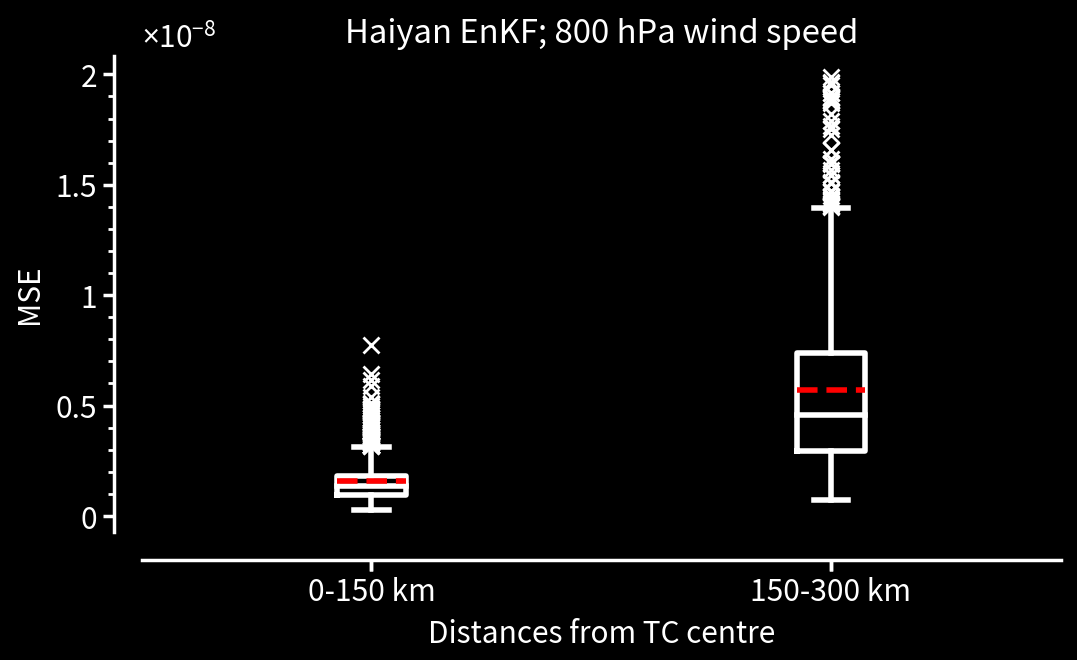

In [39]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=4.595,refaspect=1.931)
axs.format(titleabove=True,ylabel='MSE', xlabel='Distances from TC centre',title='Haiyan EnKF; 800 hPa wind speed')
axs[0].box(mse_list,means=True,marker='x',meancolor='r',fillcolor='k',edgecolors='w',linewidths=2)
plotting.adjust_spines(axs[0],['left','bottom'],10)
plt.savefig('../figures/0430/wspd800_MSE.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

##### SSIM

In [111]:
ssim800 = structral_similarity_800hPa(realdv,dvdt_full)

  0%|          | 0/869 [00:00<?, ?it/s]

  0%|          | 0/869 [00:00<?, ?it/s]

  0%|          | 0/869 [00:00<?, ?it/s]

In [121]:
import pandas as pd
df = pd.DataFrame(ssim800,columns=['SSIM'])
df[df['SSIM']>np.percentile(df['SSIM'],75)].index

In [126]:
df[df['SSIM']>np.percentile(df['SSIM'],75)].index

Int64Index([ 14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
            ...
            853, 854, 855, 856, 857, 858, 859, 860, 861, 862],
           dtype='int64', length=217)

In [137]:
rng = np.random.default_rng(42)
rng.choice(df[df['SSIM']>np.percentile(df['SSIM'],75)].index,3)

array([104, 727, 568])

/tmp/ipykernel_790492/3337303828.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


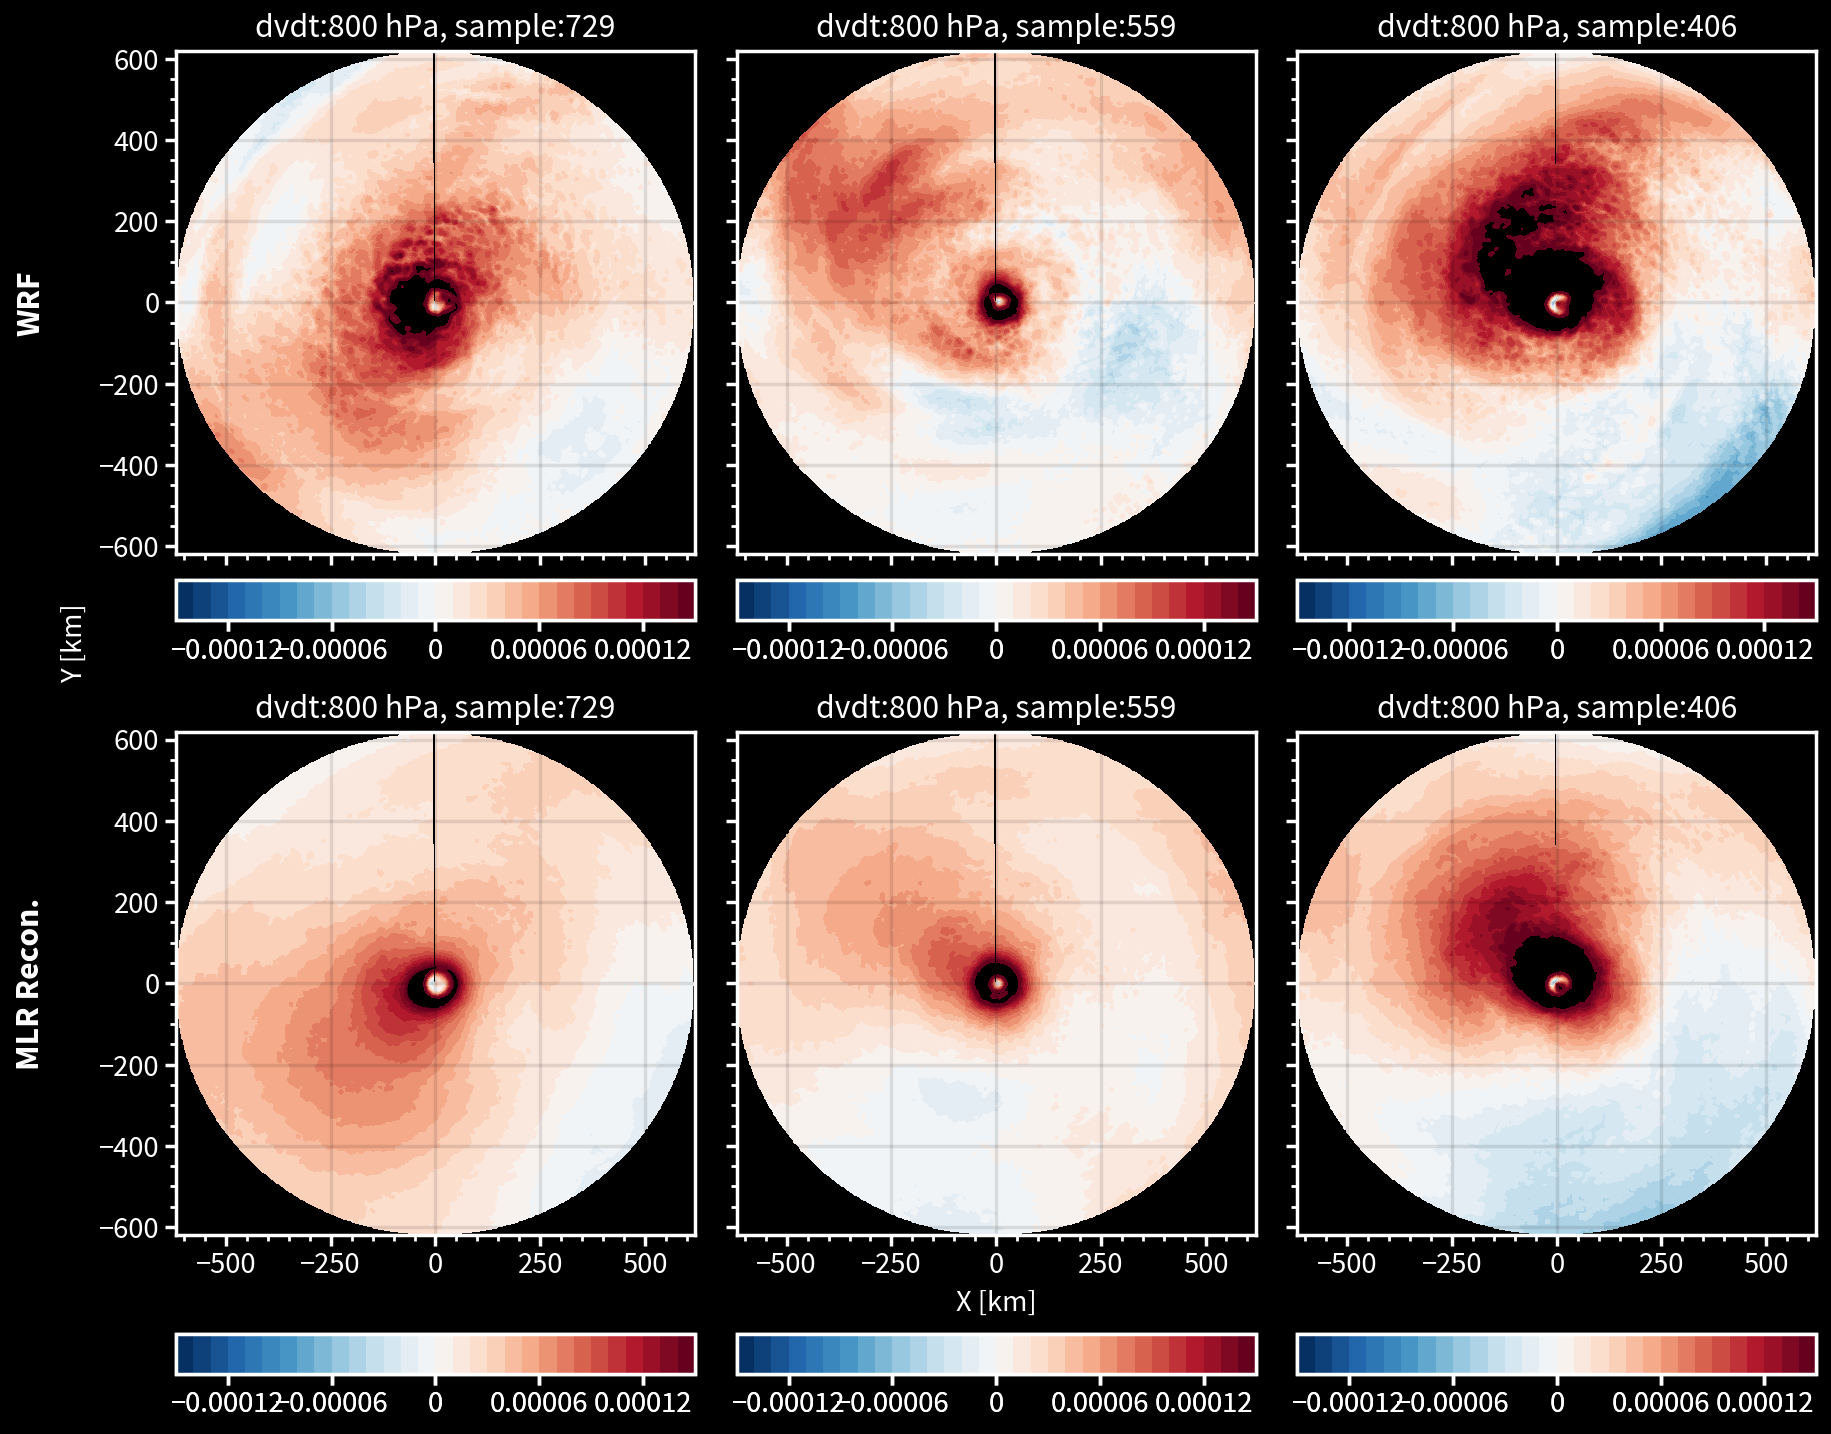

In [136]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

fig, axs = plot.subplots(ncols=3,nrows=2,axwidth=2.595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',leftlabels=('WRF','MLR Recon.'))
goodindices = rng.choice(df[df['SSIM']>np.percentile(df['SSIM'],75)].index,3)
for indices in range(3):
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(realdv.reshape(869,10,360,208)[goodindices[indices],2,:,:],ANGLE,True,False)))),0),\
                            cmap='BuRd',levels=np.linspace(-15e-5,15e-5,31),colorbar='b')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{800} hPa, sample:{goodindices[indices]}')
    
    axs[indices+3].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(dvdt_full.reshape(869,10,360,208)[goodindices[indices],2,:,:],ANGLE,True,False)))),0),\
                            cmap='BuRd',levels=np.linspace(-15e-5,15e-5,31),colorbar='b')
    axs[indices+3].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{800} hPa, sample:{goodindices[indices]}')
plt.savefig('../figures/0406/MLR_dvdtrecon_good.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

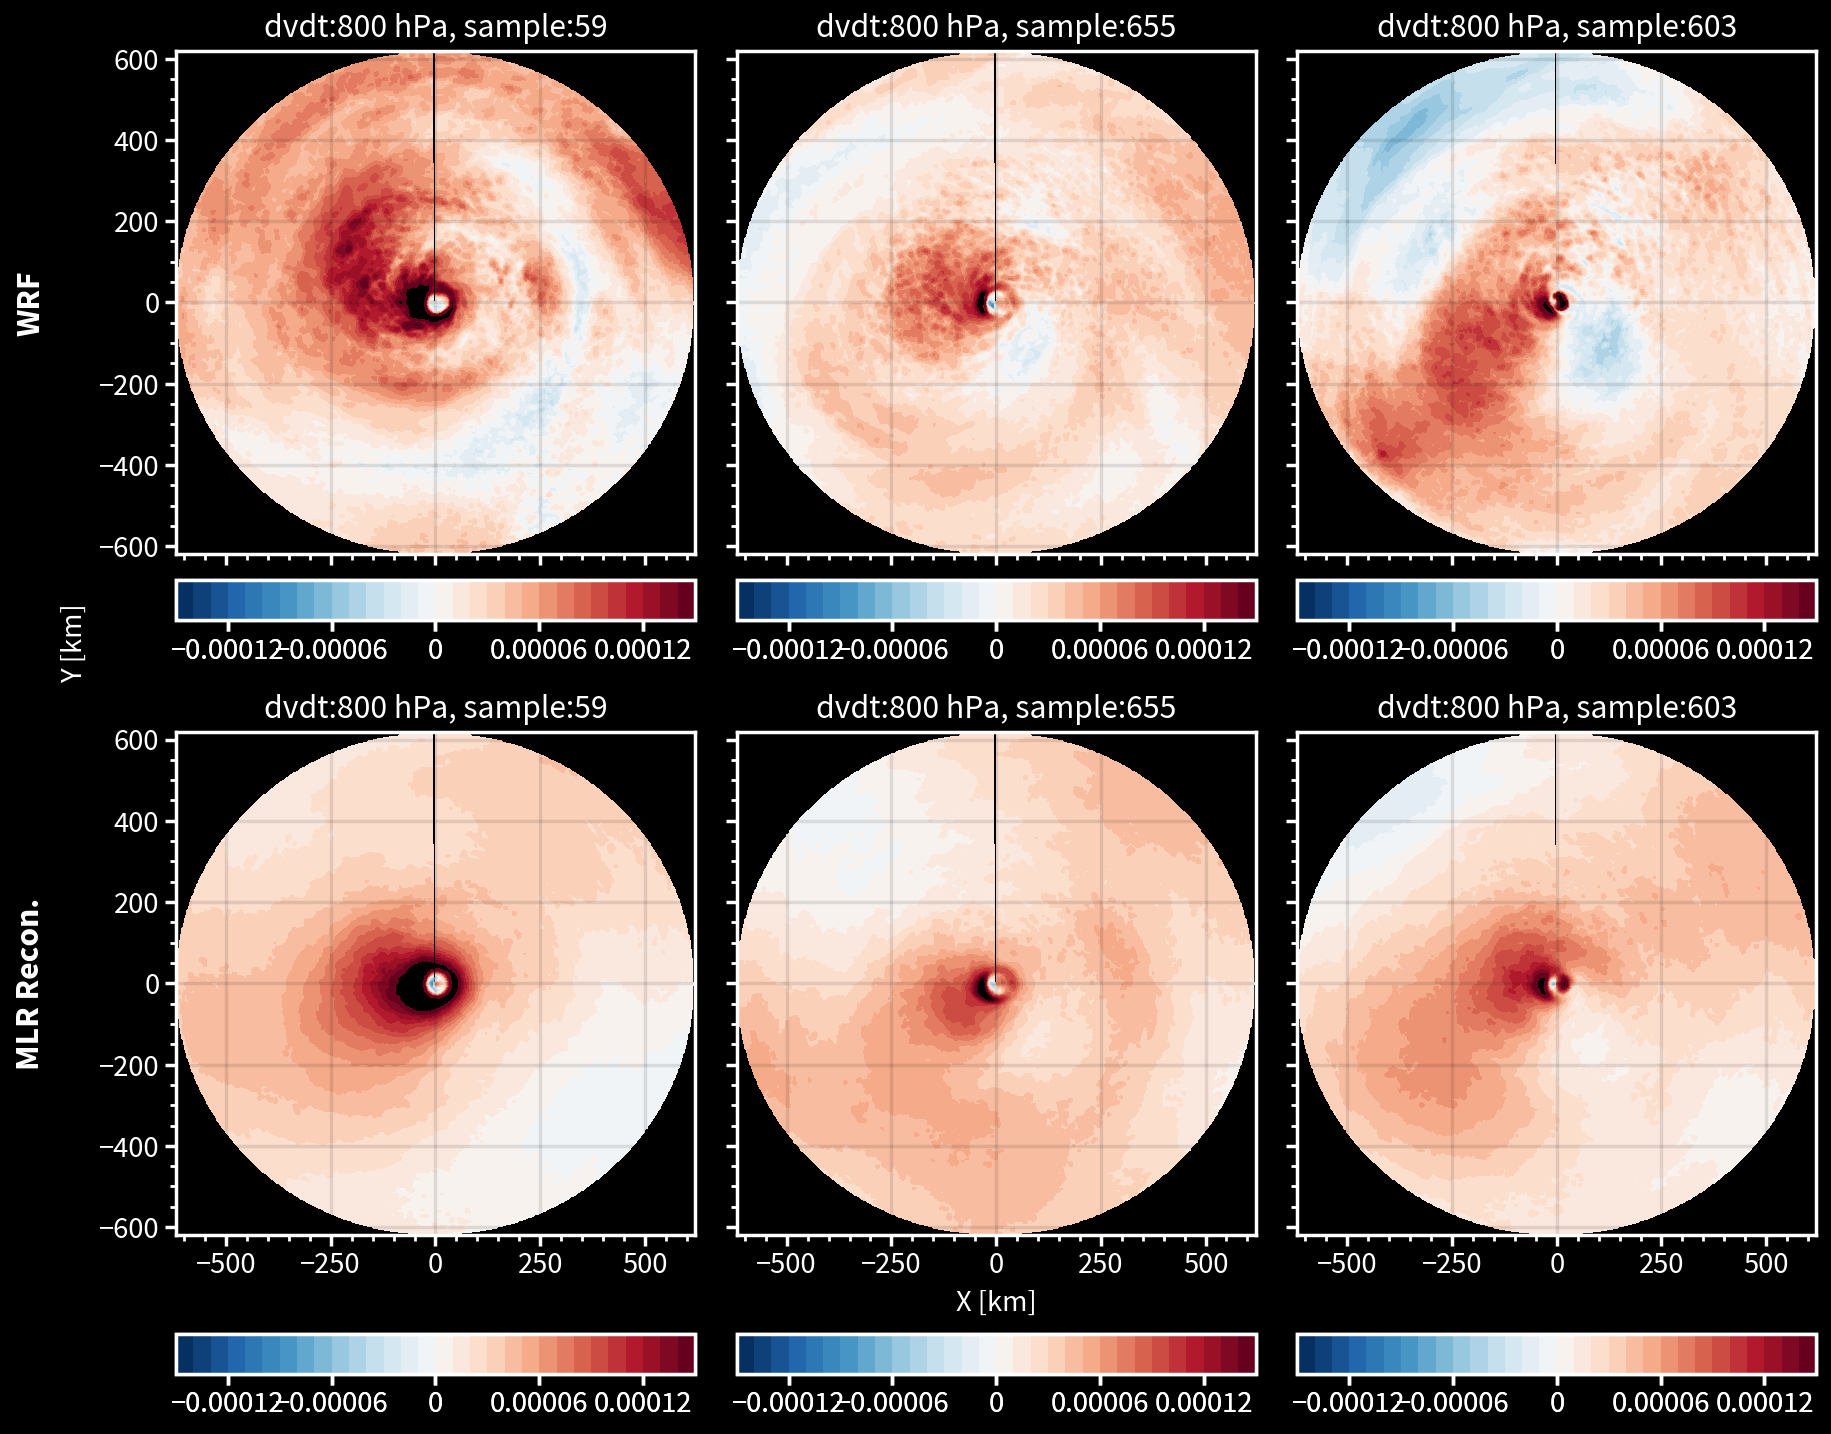

In [140]:
fig, axs = plot.subplots(ncols=3,nrows=2,axwidth=2.595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',leftlabels=('WRF','MLR Recon.'))
rng = np.random.default_rng(42)
badindices = rng.choice(df[df['SSIM']<np.percentile(df['SSIM'],15)].index,3)
for indices in range(3):
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(realdv.reshape(869,10,360,208)[badindices[indices],2,:,:],ANGLE,True,False)))),0),\
                            cmap='BuRd',levels=np.linspace(-15e-5,15e-5,31),colorbar='b')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{800} hPa, sample:{badindices[indices]}')
    
    axs[indices+3].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(dvdt_full.reshape(869,10,360,208)[badindices[indices],2,:,:],ANGLE,True,False)))),0),\
                            cmap='BuRd',levels=np.linspace(-15e-5,15e-5,31),colorbar='b')
    axs[indices+3].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{800} hPa, sample:{badindices[indices]}')
plt.savefig('../figures/0406/MLR_dvdtrecon_bad.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()